In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


In [2]:
pdb='./RegA_noCorN.pdb'
trajectory='./RegA_noCorN.xtc'
outdir='./outdir'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: ./outdir
pdb: ./RegA_noCorN.pdb
trjaectory: ./RegA_noCorN.xtc


In [3]:
trj = md.load(trajectory, top=pdb,stride=5)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 4201

Number of residues: 254

Number of frames: 6000

Starting frame: 0

Last frame: 6000

sequence:  [ASN1, MET2, LEU3, VAL4, LEU5, LYS6, LYS7, ILE8, ARG9, PHE10, TYR11, ASN12, CYS13, ALA14, ILE15, ILE16, HIS17, LEU18, ARG19, ASP20, ALA21, GLN22, LEU23, LEU24, ILE25, ARG26, THR27, LYS28, ASP29, GLY30, GLN31, THR32, LEU33, ASN34, ILE35, PRO36, PRO37, GLU38, SER39, LEU40, CYS41, TYR42, VAL43, GLU44, LYS45, ASN46, THR47, VAL48, MET49, ASP50, VAL51, ALA52, LEU53, LYS54, VAL55, LEU56, GLY57, SER58, GLY59, VAL60, PRO61, TYR62, GLU63, VAL64, TYR65, HIS66, VAL67, ASP68, SER69, ASP70, VAL71, LEU72, ARG73, CYS74, ILE75, CYS76, LYS77, VAL78, MET79, GLU80, PRO81, LEU82, LEU83, LEU84, ASP85, PRO86, GLN87, ARG88, VAL89, ASN90, HIS91, THR92, ARG93, ARG94, LYS95, ILE96, PHE97, THR98, CYS99, ALA100, VAL101, ASP102, GLU103, THR104, ASP105, THR106, ARG107, ILE108, PHE109, LYS110, ARG111, LEU112, THR113, GLY114, SER115, ASN116, VAL117, PRO118, GLN119, HIS120, ARG121, 

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Here I evaluate the secondary structure atributes for RegA alone as a baseline.

In [6]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'H', 'H', 'C'],
       ['C', 'C', 'E', ..., 'H', 'H', 'C'],
       ['C', 'C', 'C', ..., 'H', 'H', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

Helix fractions saved to ./outdir\RegA_noCorN_helix_fractions.dat
Sheet fractions saved to ./outdir\RegA_noCorN_sheet_fractions.dat


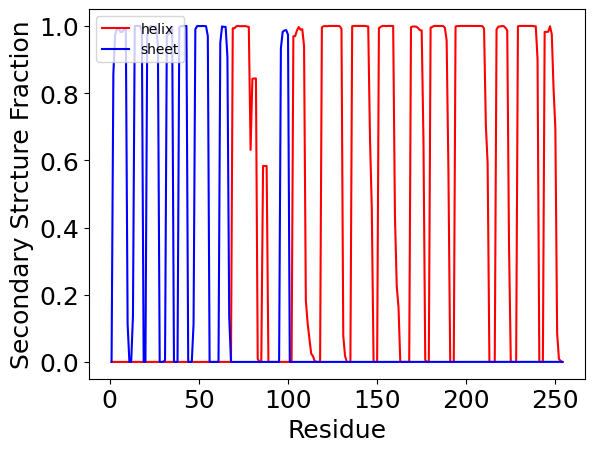

In [179]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

# Save helix fractions to a .dat file
helix_data = np.column_stack((residue_num, Hprop))
outfile_helix = os.path.join(outdir, 'RegA_noCorN_helix_fractions.dat')
np.savetxt(outfile_helix, helix_data, header='Residue HelixFraction', comments='')
print(f"Helix fractions saved to {outfile_helix}")

# Save sheet fractions to a .dat file
sheet_data = np.column_stack((residue_num, Eprop))
outfile_sheet = os.path.join(outdir, 'RegA_noCorN_sheet_fractions.dat')
np.savetxt(outfile_sheet, sheet_data, header='Residue SheetFraction', comments='')
print(f"Sheet fractions saved to {outfile_sheet}")

SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 119
 120 121 122 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142
 143 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174
 175 180 181 182 183 184 185 186 187 188 189 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229
 230 231 232 233 234 235 236 237 238 239 240 244 245 246 247 248]
SS: E [  3   4   5   6   7   8   9  14  15  16  17  18  21  22  23  24  25  26
  27  32  33  34  35  39  40  41  42  43  48  49  50  51  52  53  54  55
  62  63  64  65  66  96  97  98  99 100]
SS: I []
SS: G []
SS: B []
SS: T [ 28  29  45  46 131 132 177 191 225]
SS: S [ 11  12  19  20  37  38  57  58  59  95 148 165 227 241 242]
SS:   [  1  31  36  44  60  61  68  90  93  94 101 102 118 149 150 166 167 168
 179 192 193 213 214 216 226 243 252 253 254]


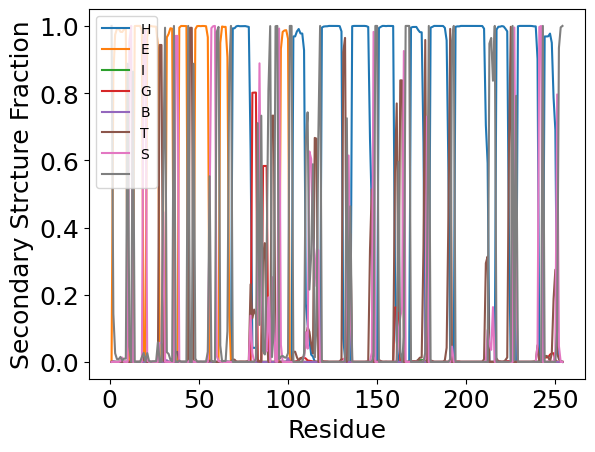

In [8]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1   # you could do this with an if as well                                                                                   
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 119
 120 121 122 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142
 143 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174
 175 180 181 182 183 184 185 186 187 188 189 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229
 230 231 232 233 234 235 236 237 238 239 240 244 245 246 247 248]
SS: E [  3   4   5   6   7   8   9  14  15  16  17  18  21  22  23  24  25  26
  27  32  33  34  35  39  40  41  42  43  48  49  50  51  52  53  54  55
  62  63  64  65  66  96  97  98  99 100]
SS: I []
SS: G []
SS: B []
SS: T [ 28  29  45  46 131 132 177 191 225]
SS: S [ 11  12  19  20  37  38  57  58  59  95 148 165 227 241 242]
SS:   [  1  31  36  44  60  61  68  90  93  94 101 102 118 149 150 166 167 168
 179 192 193 213 214 216 226 243 252 253 254]


(1.0, 149.0)

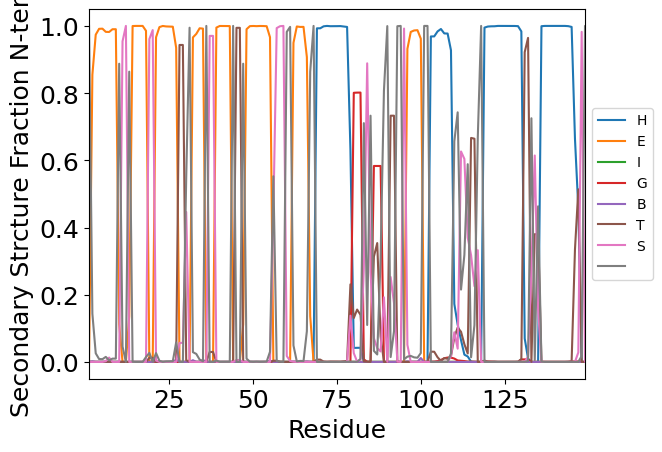

In [193]:
# zoom in on N terminal  domain
for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction N-term', size=18)
plt.tick_params(labelsize=18)
plt.xlim(1,149)

SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 119
 120 121 122 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142
 143 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174
 175 180 181 182 183 184 185 186 187 188 189 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229
 230 231 232 233 234 235 236 237 238 239 240 244 245 246 247 248]
SS: E [  3   4   5   6   7   8   9  14  15  16  17  18  21  22  23  24  25  26
  27  32  33  34  35  39  40  41  42  43  48  49  50  51  52  53  54  55
  62  63  64  65  66  96  97  98  99 100]
SS: I []
SS: G []
SS: B []
SS: T [ 28  29  45  46 131 132 177 191 225]
SS: S [ 11  12  19  20  37  38  57  58  59  95 148 165 227 241 242]
SS:   [  1  31  36  44  60  61  68  90  93  94 101 102 118 149 150 166 167 168
 179 192 193 213 214 216 226 243 252 253 254]


(150.0, 257.0)

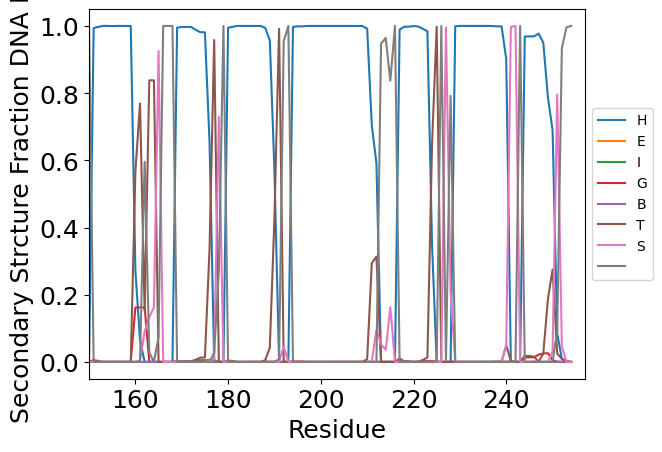

In [194]:
# zoom in on DNA binding domain
for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction DNA BD', size=18)
plt.tick_params(labelsize=18)
plt.xlim(150,257)

In [45]:
#Here is a calculator to help my brain
def correct_residue_numbers(actual_residue_nums):
    # Adjust each residue number in the list by subtracting 22
    adjusted_residue_nums = [num - 22 for num in actual_residue_nums]
    
    # Check if any adjusted residue number is invalid
    for num in adjusted_residue_nums:
        if num < 0:
            raise ValueError(f"The adjusted residue number {num + 22} is out of bounds.")
    
    return adjusted_residue_nums
#Here I am inputing residues that are either known to be important for inhibition or are hypothesized to be. 
actual_residue_nums = [24, 26, 29, 32, 87, 149, 188, 222, 223]
residue_indices = correct_residue_numbers(actual_residue_nums)
print(f"The indices for the actual residue numbers {actual_residue_nums} are {residue_indices}.")

The indices for the actual residue numbers [24, 26, 29, 32, 87, 149, 188, 222, 223] are [2, 4, 7, 10, 65, 127, 166, 200, 201].


In [6]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [7]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [8]:
def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

In [12]:
def print_residue_info(trj, indices):
    for idx in indices:
        residue = trj.topology.residue(idx)
        print(f"Residue {residue.index + 1}: {residue.name} (resSeq {residue.resSeq})")

print_residue_info(trj, res_interest)

Residue 3: LEU (resSeq 3)
Residue 5: LEU (resSeq 5)
Residue 8: ILE (resSeq 8)
Residue 11: TYR (resSeq 11)
Residue 66: HIS (resSeq 66)
Residue 128: TYR (resSeq 128)
Residue 167: TRP (resSeq 167)
Residue 201: ILE (resSeq 201)
Residue 202: ARG (resSeq 202)
Residue 63: GLU (resSeq 63)


Residue 3


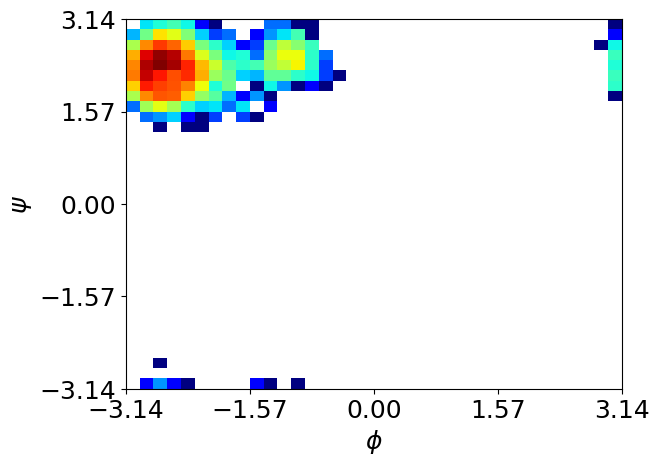

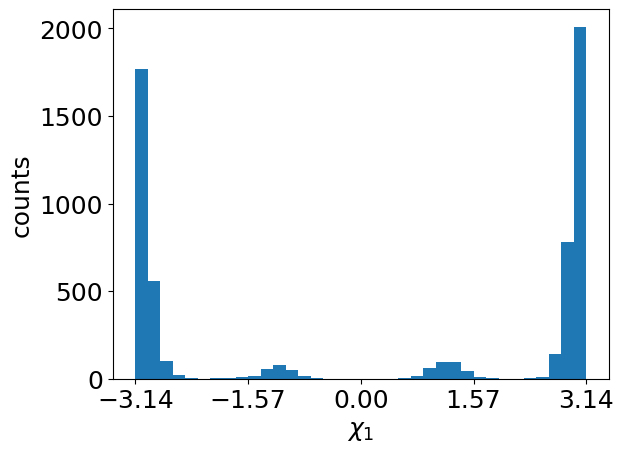

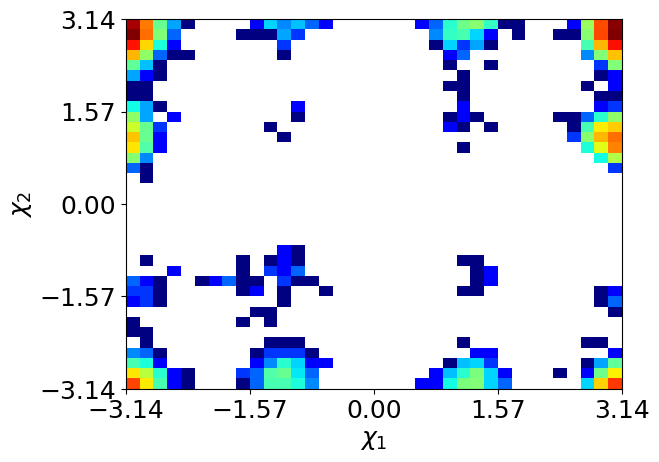

Residue 5


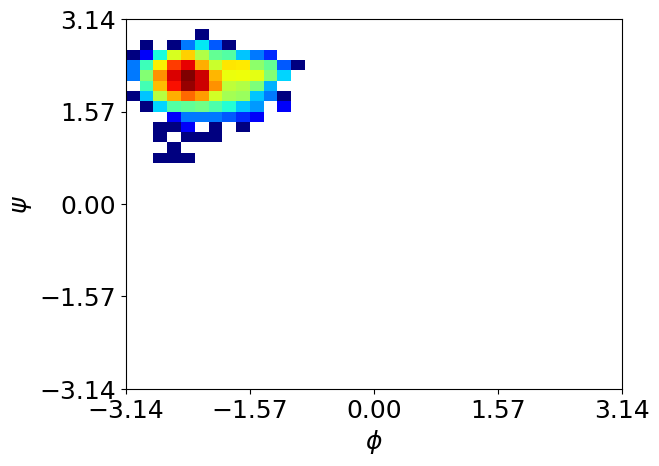

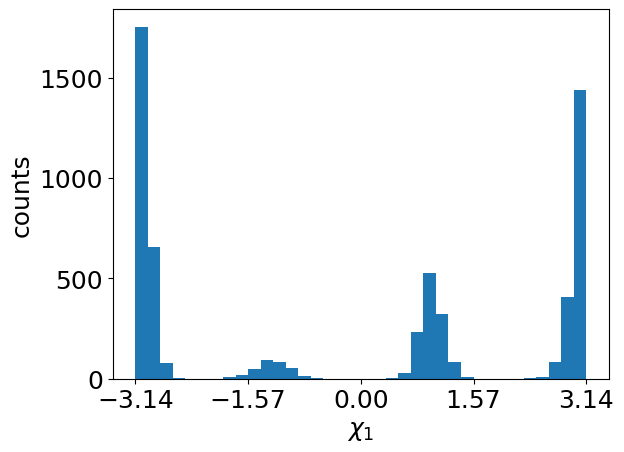

Residue 8


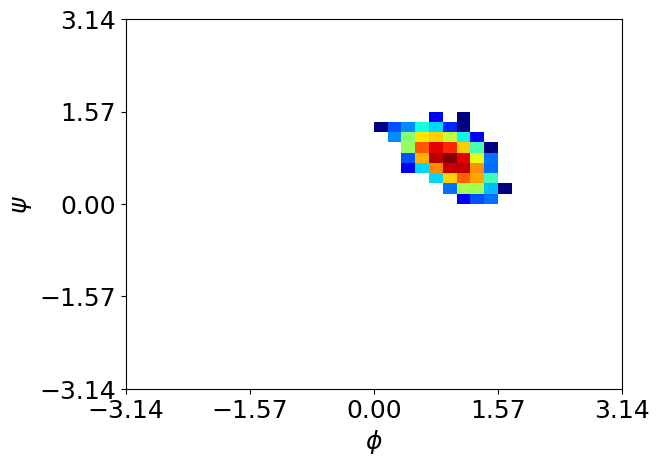

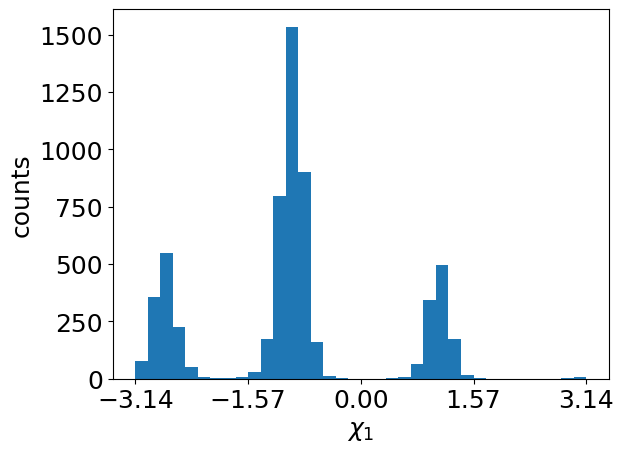

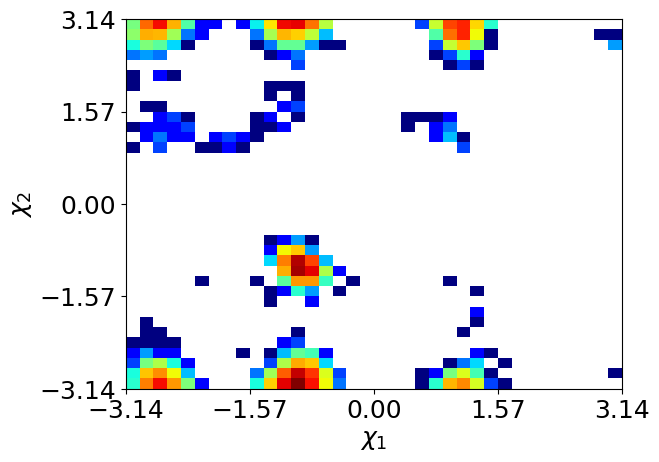

Residue 11


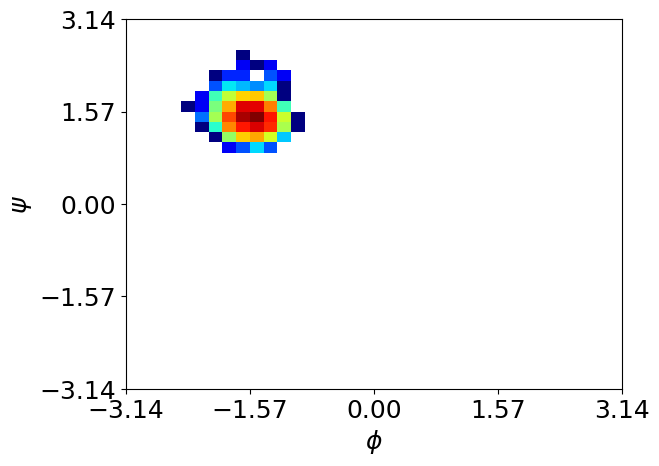

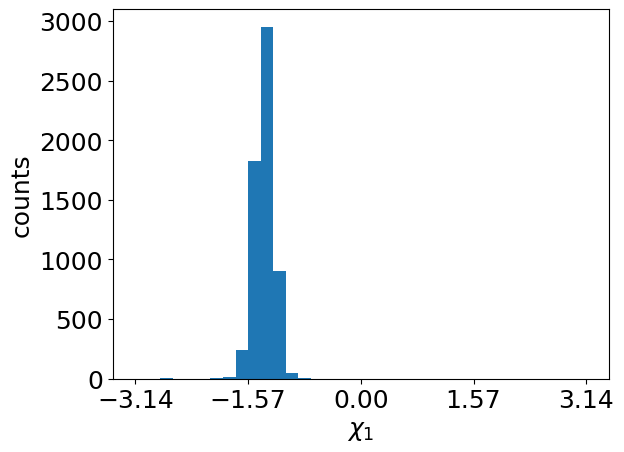

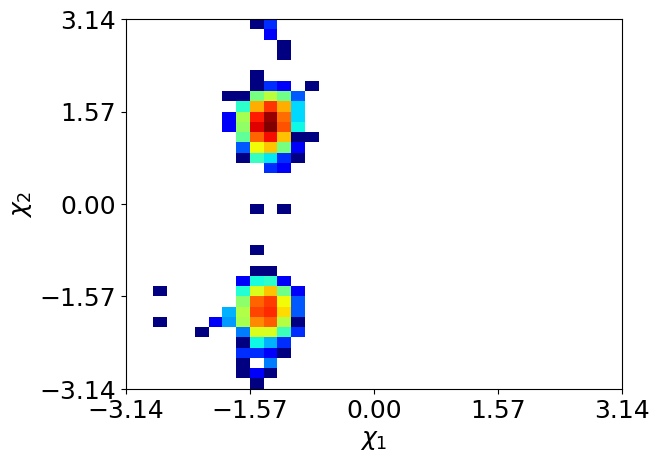

Residue 66


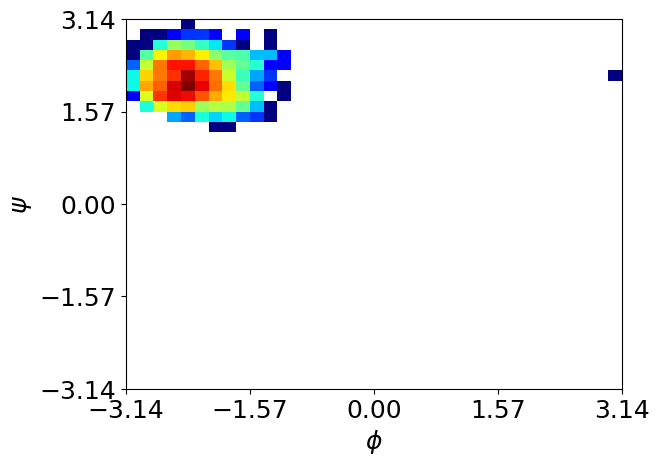

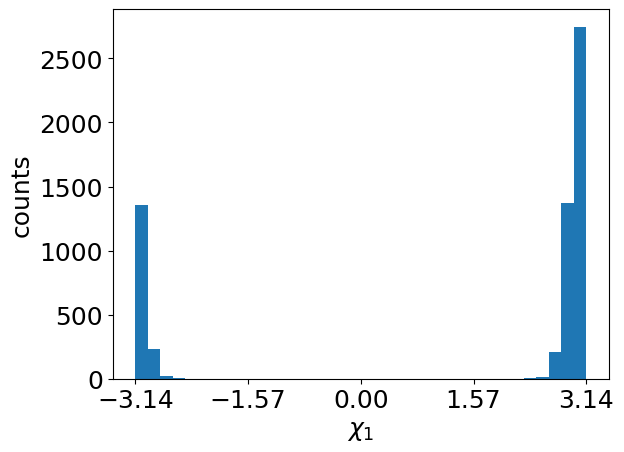

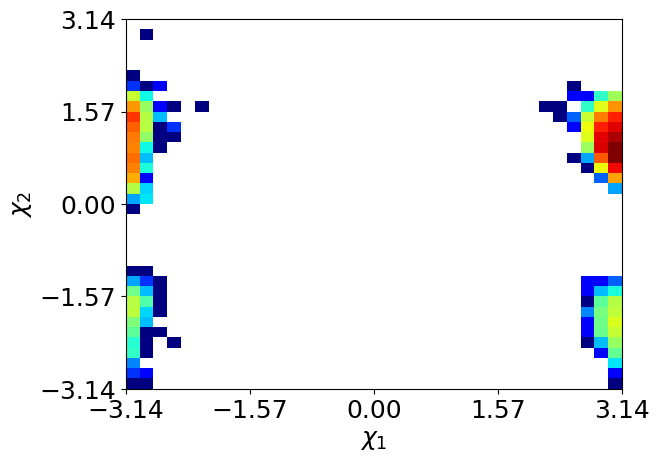

Residue 128


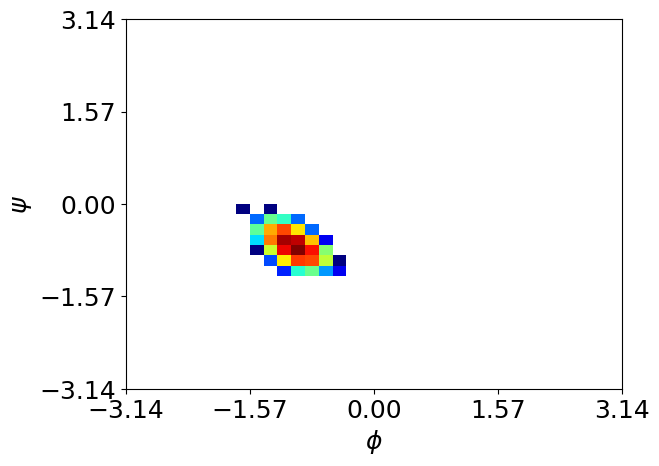

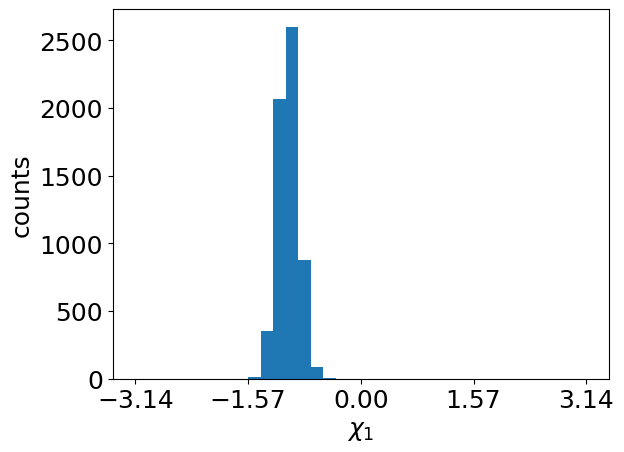

Residue 167


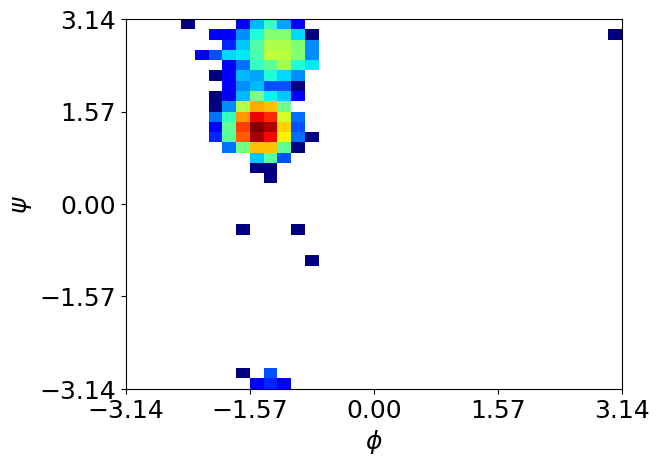

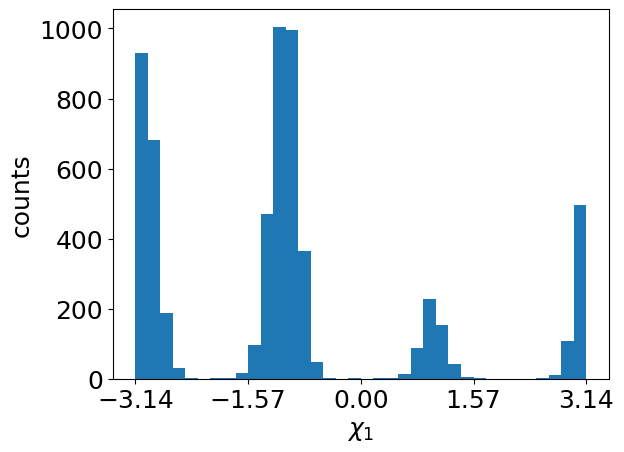

Residue 201


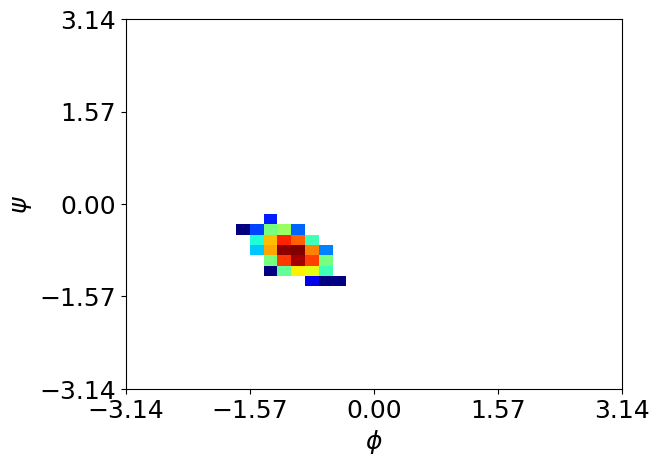

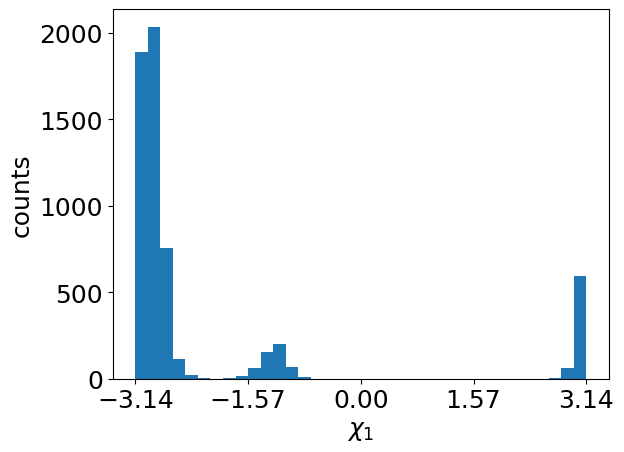

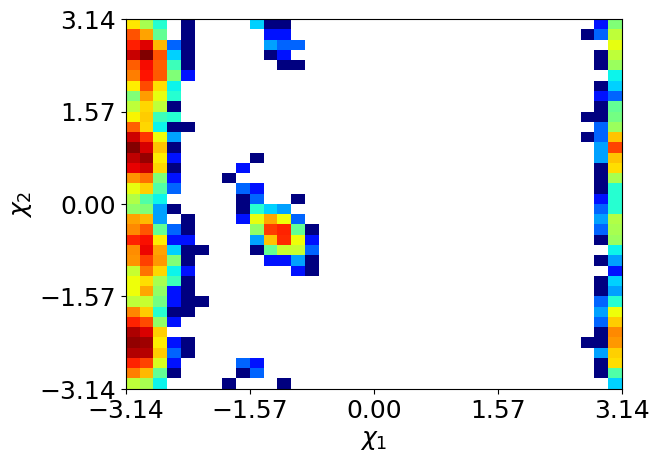

Residue 202


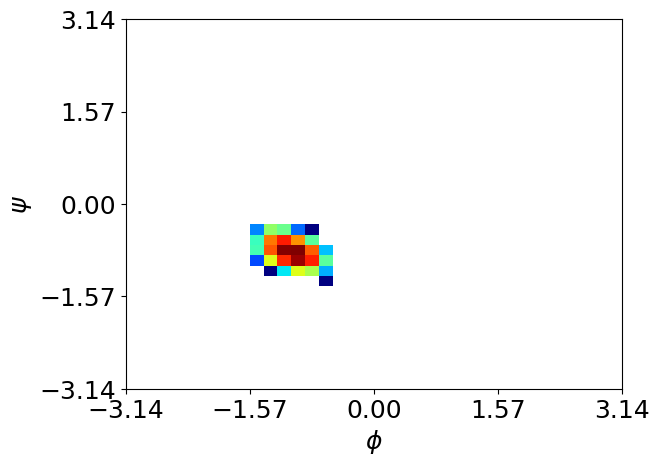

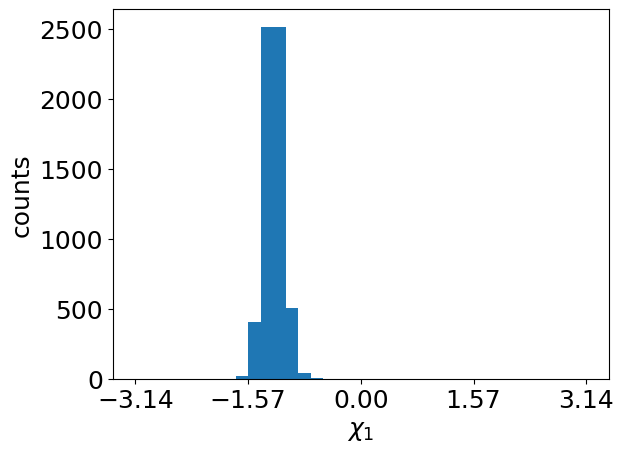

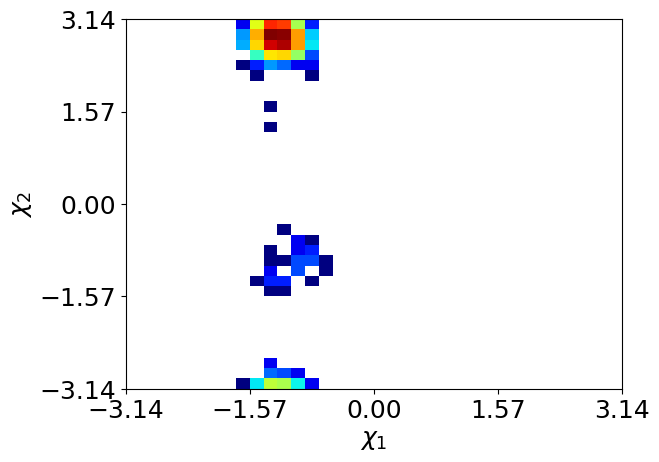

Residue 63


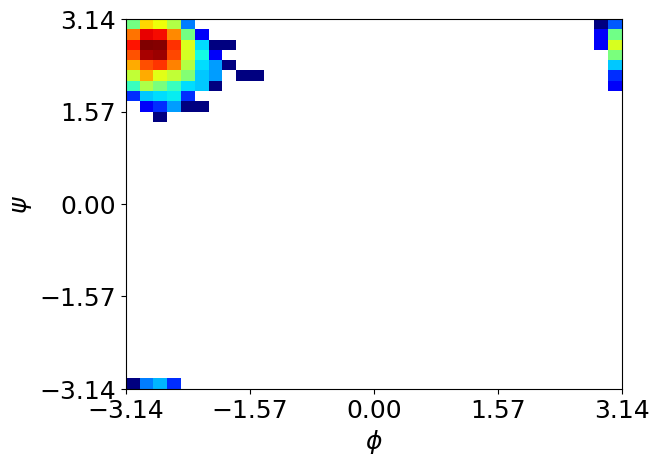

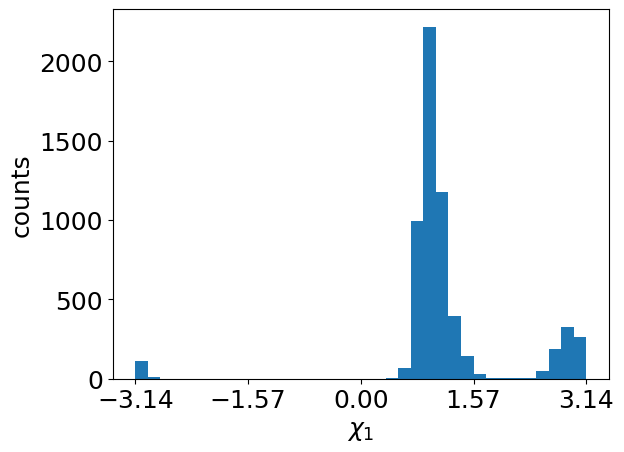

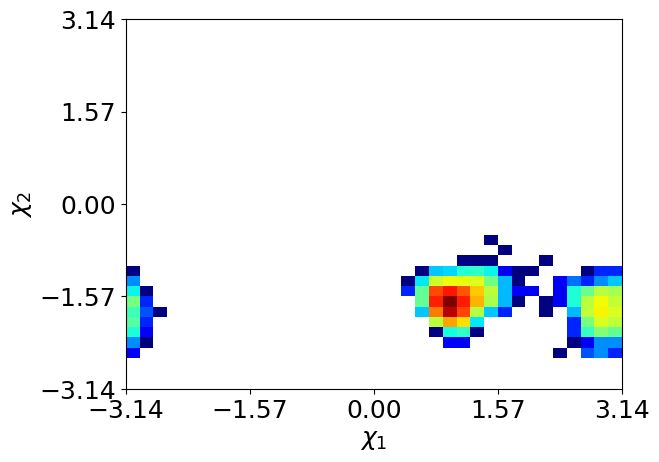

<Figure size 640x480 with 0 Axes>

In [11]:
res_interest= [2, 4, 7, 10, 65, 127, 166, 200, 201, 62]
for i in res_interest:
    print("Residue", i+1)
    plot_phipsi(i)
    plt.clf()
    plot_chi(i)
    plt.clf()


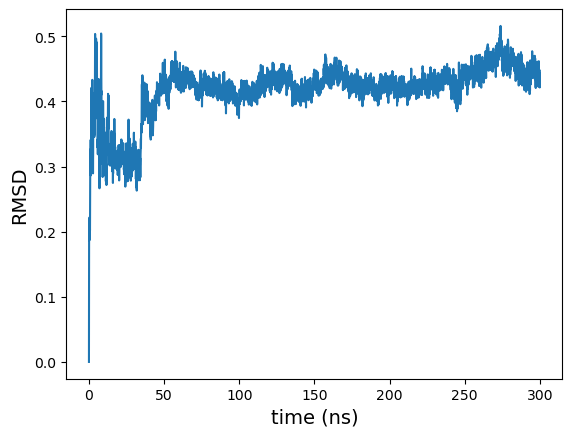

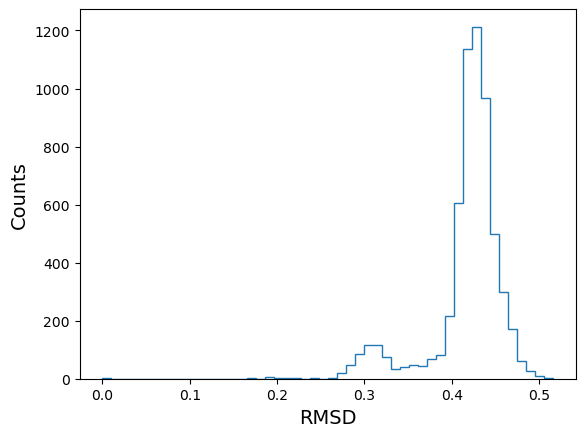

In [9]:
#Calculate RMSD
time=np.linspace(0,300,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()
# Combine time and rmsd into a single array for saving
data = np.column_stack((time, rmsd))

# Save the data to a .dat file
outfile = os.path.join(outdir, 'RegA_noCorN_rmsd_data.dat')
np.savetxt(outfile, data, header='time(ns) rmsd', comments='')

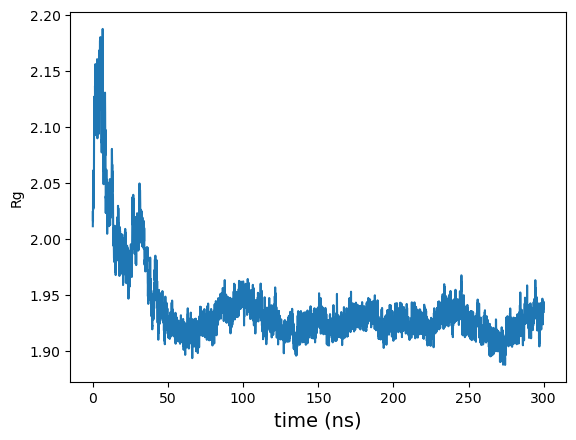

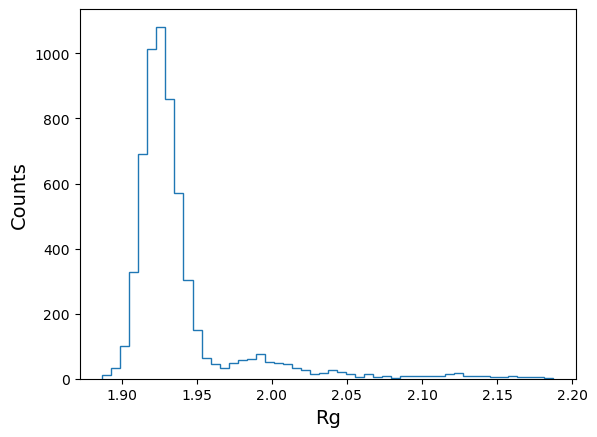

Time series data saved to ./outdir\RegA_noCorN_time_series_Rg.dat


In [14]:
#Calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None) 
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()
# Combine time and rg into a single array for saving
data = np.column_stack((time, rg))

# Save the data to a .dat file in the output directory
outfile_time_series = os.path.join(outdir, 'RegA_noCorN_time_series_Rg.dat')
np.savetxt(outfile_time_series, data, header='time(ns) Rg', comments='')
print(f"Time series data saved to {outfile_time_series}")

In [16]:
#Identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
#donor on left, acceptor on the right, looks at angles to see if acceptable H bond is available there

LEU3-N -- LEU53-O
LEU5-N -- VAL51-O
LYS7-N -- ASP50-OD1
LYS7-N -- ASP50-OD2
ILE8-N -- MET49-O
ARG9-NH1 -- ASN46-OD1
ARG9-NH1 -- GLU190-OE1
ARG9-NH1 -- GLU190-OE2
ARG9-NH2 -- ASN192-OD1
ARG9-NH2 -- GLU190-OE1
ARG9-NH2 -- GLU190-OE2
ARG9-NH2 -- GLU190-O
PHE10-N -- THR47-O
TYR11-N -- ARG9-O
ASN12-N -- TYR204-OH
ASN12-ND2 -- VAL67-O
ASN12-ND2 -- CYS13-O
ALA14-N -- VAL43-O
ILE15-N -- TYR65-O
ILE16-N -- CYS41-O
HIS17-N -- GLU63-O
HIS17-NE2 -- THR106-OG1
LEU18-N -- SER39-O
ARG19-N -- PRO61-O
ARG19-NE -- GLU38-OE1
ARG19-NE -- GLU38-OE2
ARG19-NH1 -- GLU38-OE1
ARG19-NH1 -- GLU38-OE2
ARG19-NH1 -- GLU103-OE1
ARG19-NH1 -- GLU103-OE2
ARG19-NH2 -- GLU38-OE1
ARG19-NH2 -- GLU38-OE2
ARG19-NH2 -- GLU103-OE1
ARG19-NH2 -- GLU103-OE2
ASP20-N -- PRO61-O
ALA21-N -- ARG19-O
GLN22-N -- LYS54-O
GLN22-NE2 -- ASN34-OD1
LEU23-N -- ILE35-O
LEU24-N -- ALA52-O
ILE25-N -- LEU33-O
ARG26-N -- ASP50-O
ARG26-NE -- ASP50-OD1
ARG26-NE -- ASP50-OD2
ARG26-NH2 -- ASP50-OD1
ARG26-NH2 -- ASP50-OD2
THR27-N -- GLN31-O
LYS28-N -- VA

In [17]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[ 33  34 881] LEU3-N LEU53-O
[ 68  69 852] LEU5-N VAL51-O
[109 110 833] LYS7-N ASP50-OD1
[109 110 834] LYS7-N ASP50-OD2
[131 132 824] ILE8-N MET49-O
[166 167 772] ARG9-NH1 ASN46-OD1
[ 166  168 3146] ARG9-NH1 GLU190-OE1
[ 166  168 3147] ARG9-NH1 GLU190-OE2
[ 169  170 3169] ARG9-NH2 ASN192-OD1
[ 169  171 3146] ARG9-NH2 GLU190-OE1
[ 169  171 3147] ARG9-NH2 GLU190-OE2
[ 169  171 3149] ARG9-NH2 GLU190-O
[174 175 791] PHE10-N THR47-O
[194 195 173] TYR11-N ARG9-O
[ 215  216 3372] ASN12-N TYR204-OH
[ 224  225 1099] ASN12-ND2 VAL67-O
[224 226 239] ASN12-ND2 CYS13-O
[240 241 726] ALA14-N VAL43-O
[ 250  251 1066] ILE15-N TYR65-O
[269 270 689] ILE16-N CYS41-O
[ 288  289 1029] HIS17-N GLU63-O
[ 299  300 1727] HIS17-NE2 THR106-OG1
[305 306 659] LEU18-N SER39-O
[324 325 993] ARG19-N PRO61-O
[337 338 645] ARG19-NE GLU38-OE1
[337 338 646] ARG19-NE GLU38-OE2
[340 341 645] ARG19-NH1 GLU38-OE1
[340 341 646] ARG19-NH1 GLU38-OE2
[ 340  342 1687] ARG19-NH1 GLU103-OE1
[ 340  342 1688] ARG19-NH1 GLU103-OE2
[34

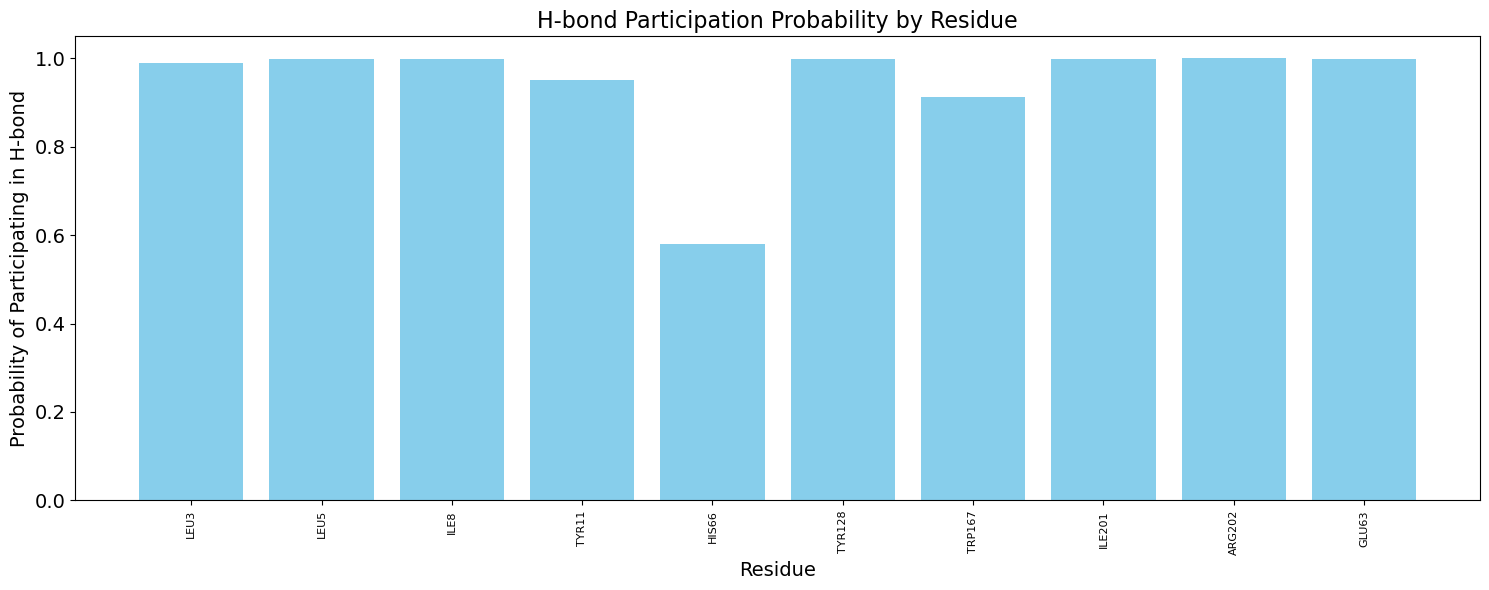

In [19]:
# Define residues of interest
residues_of_interest = [2, 4, 7, 10, 65, 127, 166, 200, 201, 62]

# Initialize a dictionary to track H-bond participation for residues of interest
hbond_participation = {res: np.zeros(trj.n_frames) for res in residues_of_interest}

# Iterate over each frame
for frame in range(trj.n_frames):
    hbonds_frame = md.baker_hubbard(trj[frame], periodic=False)
    for hbond in hbonds_frame:
        donor_residue = trj.topology.atom(hbond[0]).residue.index
        acceptor_residue = trj.topology.atom(hbond[2]).residue.index
        if donor_residue in residues_of_interest:
            hbond_participation[donor_residue][frame] = 1
        if acceptor_residue in residues_of_interest:
            hbond_participation[acceptor_residue][frame] = 1

# Calculate the probability of each residue participating in an H-bond
hbond_probability = {res: np.mean(hbond_participation[res]) for res in hbond_participation}

# Extract residues of interest and their H-bond participation probabilities
residues = residues_of_interest
probabilities = [hbond_probability[res] for res in residues]

# Convert residue indices to residue names and sequence numbers
residue_labels = [f"{trj.topology.residue(res).name}{trj.topology.residue(res).resSeq}" for res in residues]

data = np.column_stack((residues, probabilities))
outfile = os.path.join(outdir, 'RegA_noCorN_hbond_prob_interesting_res_data.dat')
np.savetxt(outfile, data, header='time(ns) rmsd', comments='')

# Plot the H-bond participation probability
plt.figure(figsize=(15, 6))
plt.bar(residue_labels, probabilities, color='skyblue')
plt.xlabel('Residue', size=14)
plt.ylabel('Probability of Participating in H-bond', size=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(size=14)
plt.title('H-bond Participation Probability by Residue', size=16)
plt.tight_layout()
plt.show()

[ 33  34 881] LEU3-N LEU53-O
[863 864  51] LEU53-N LEU3-O


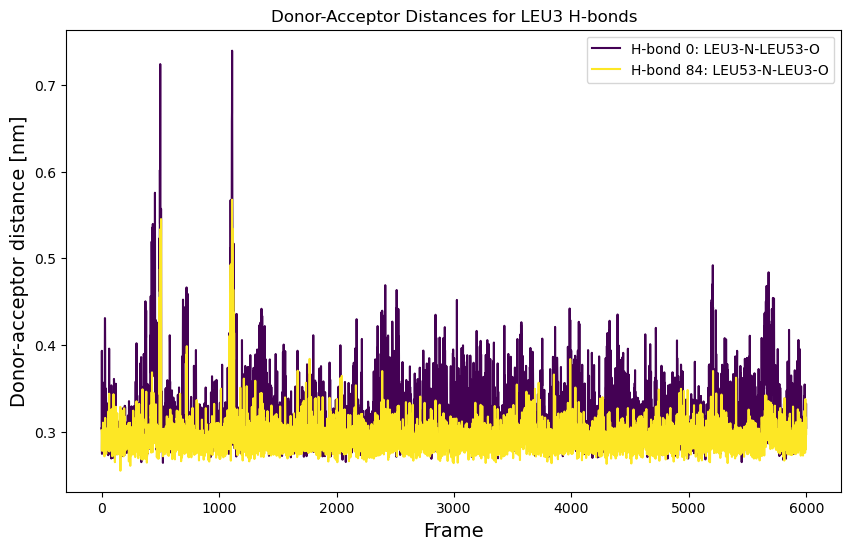

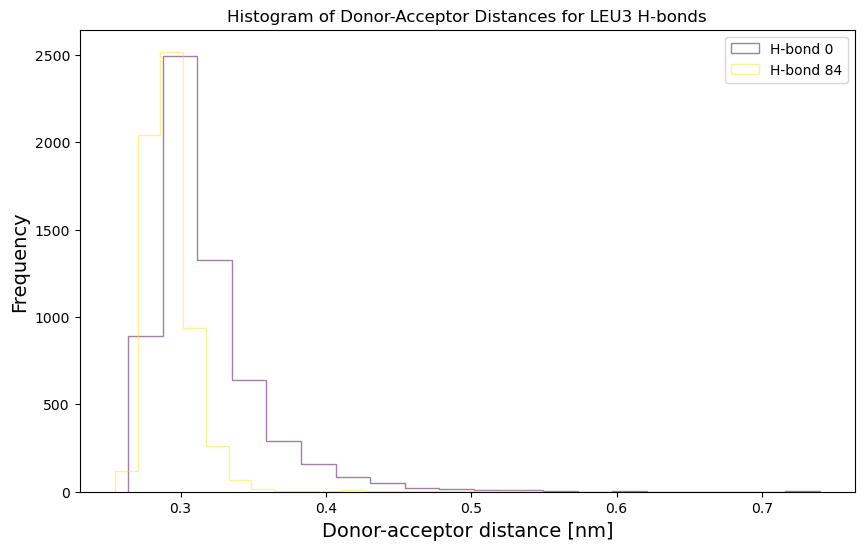

[ 68  69 852] LEU5-N VAL51-O
[837 838  86] VAL51-N LEU5-O


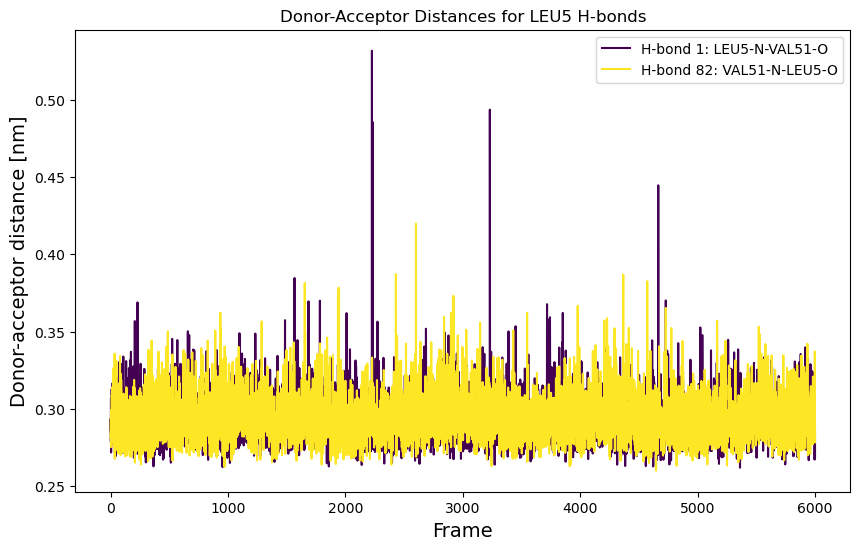

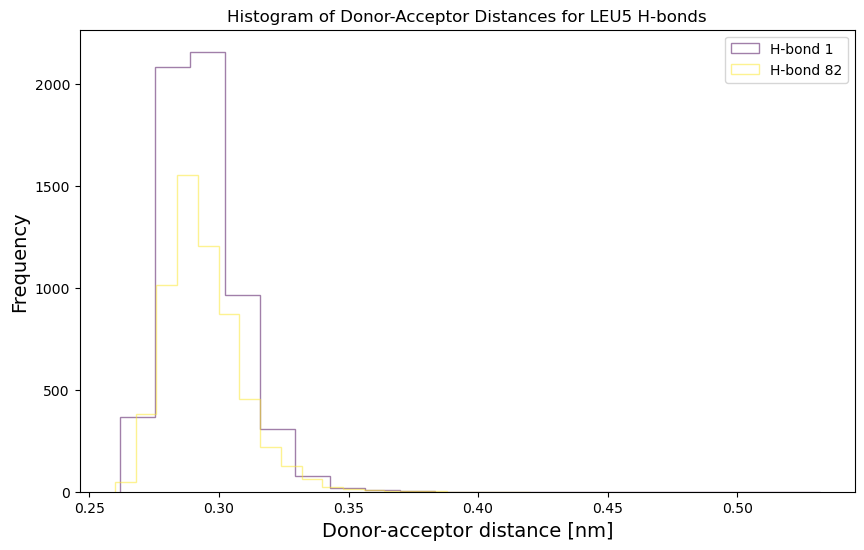

[131 132 824] ILE8-N MET49-O
[808 809 149] MET49-N ILE8-O


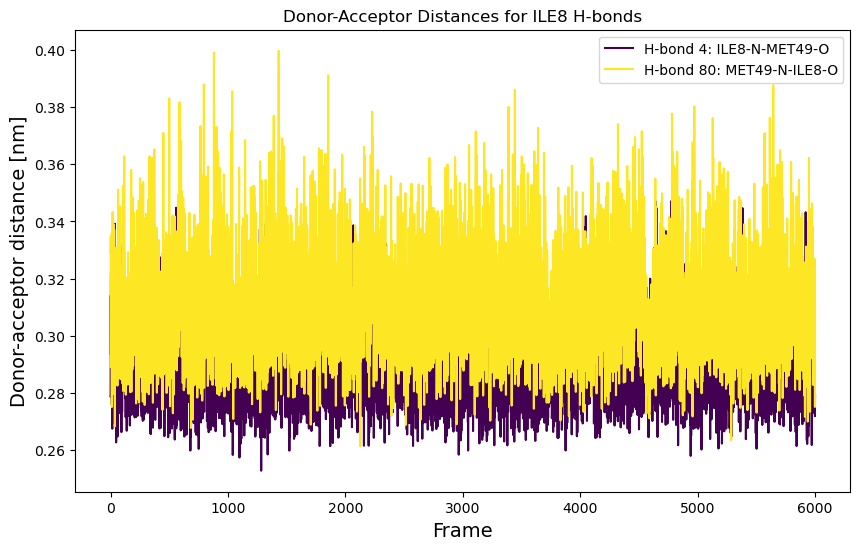

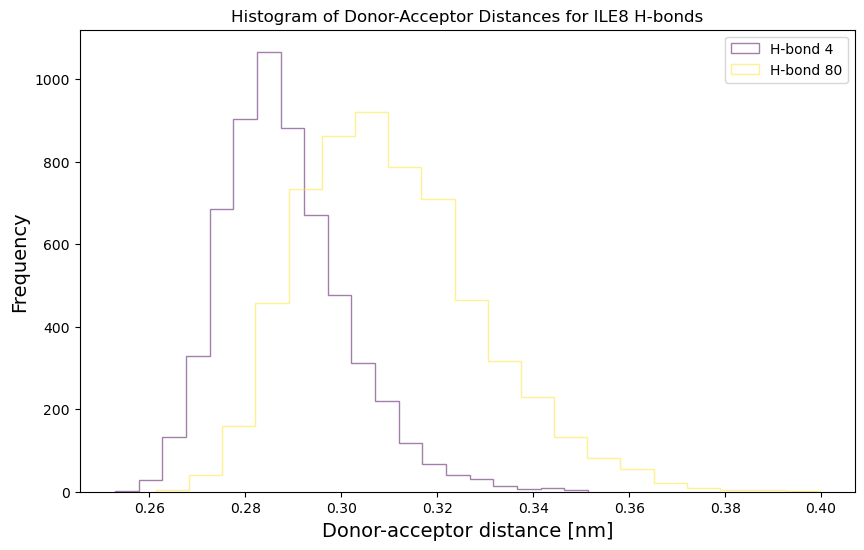

[194 195 173] TYR11-N ARG9-O
[ 207  208 3295] TYR11-OH ASP200-OD1
[478 479 512] THR27-OG1 ASP29-OD1


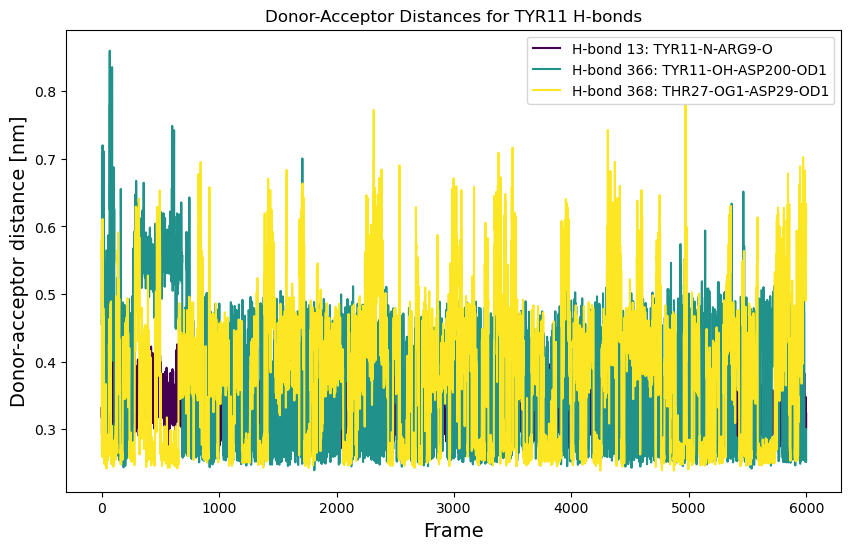

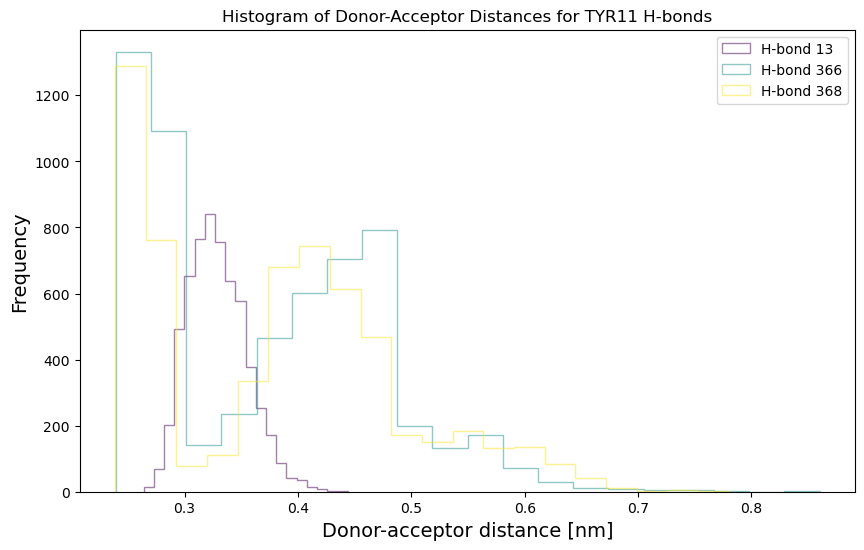

[1067 1068 4194] HIS66-N GLN254-OE1
[4195 4196 1075] GLN254-NE2 HIS66-ND1


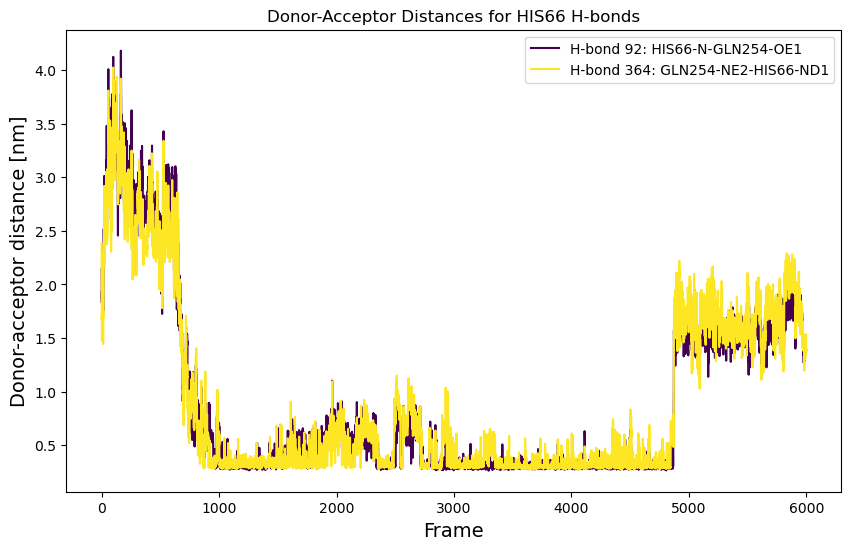

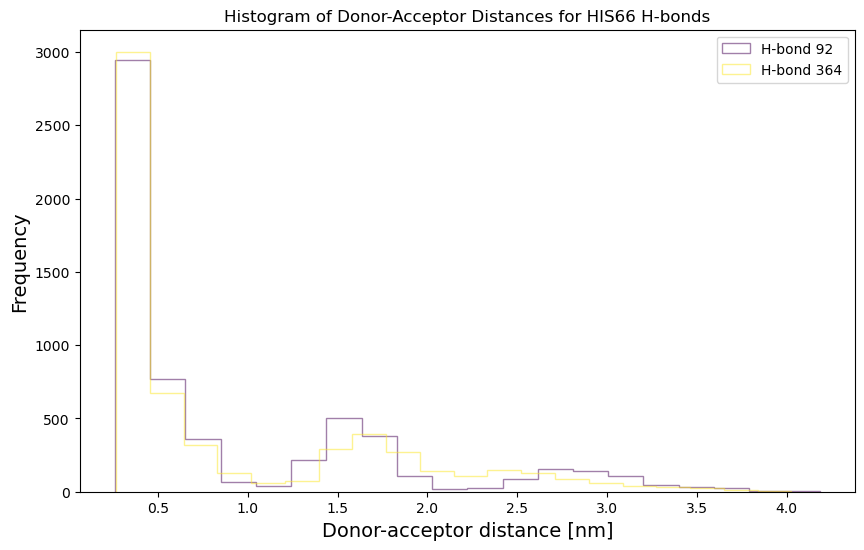

[2104 2105 2048] TYR128-N TYR124-O
[2117 2118 1713] TYR128-OH ASP105-OD1
[2117 2118 1714] TYR128-OH ASP105-OD2
[2170 2171 2124] SER131-OG TYR128-O


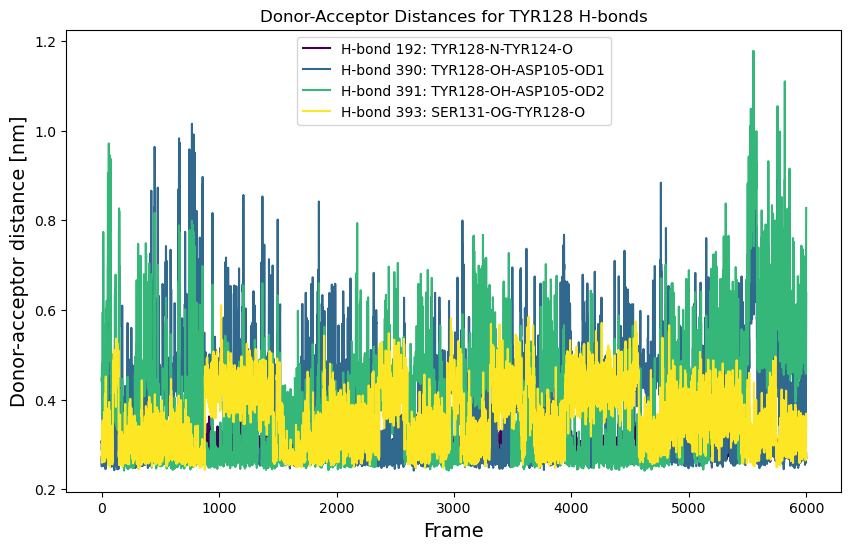

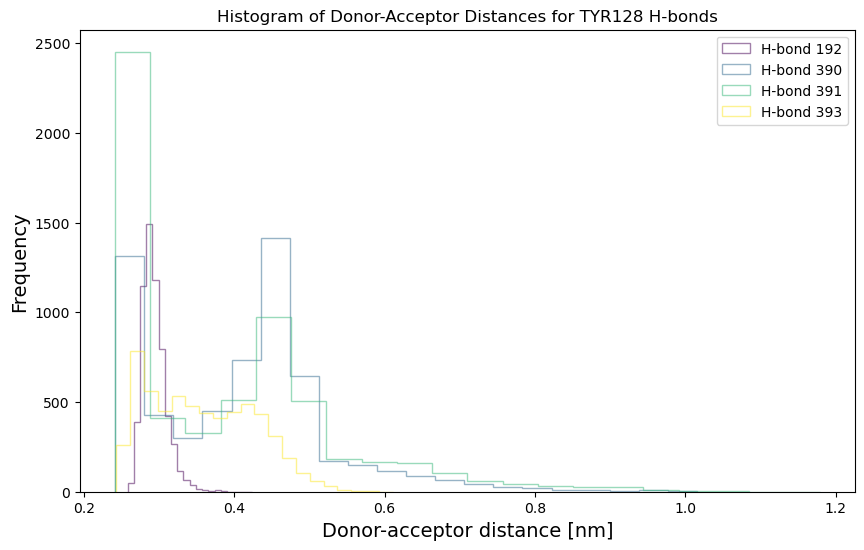

[2729 2730 2717] TRP167-N ARG165-O
[2739 2740 2663] TRP167-NE1 ASP162-O


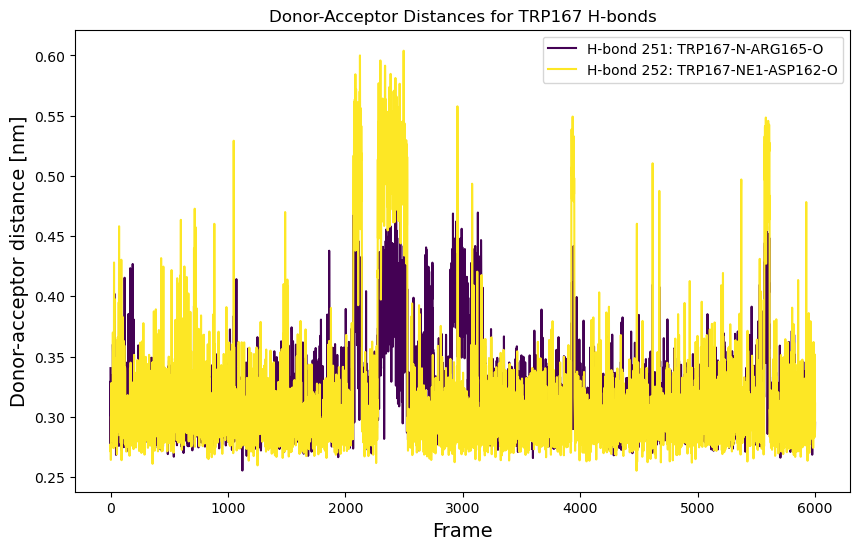

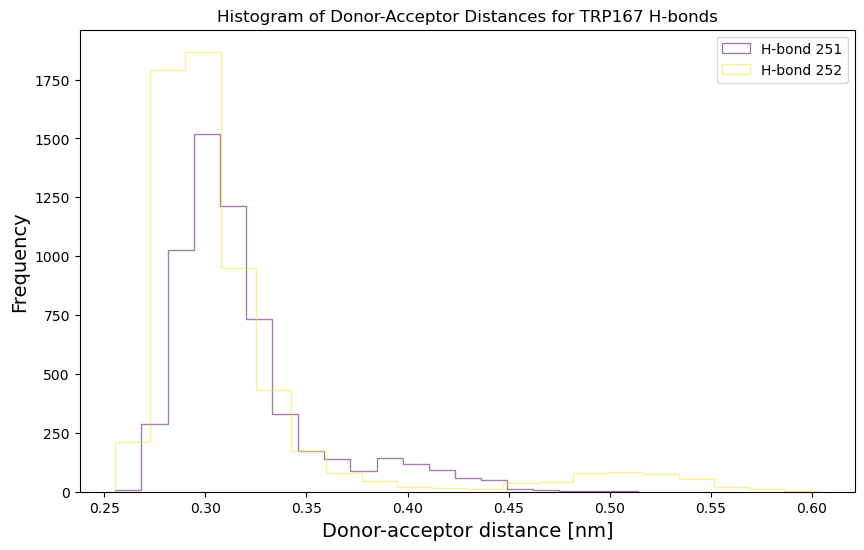

[3299 3300 3251] ILE201-N LEU197-O
[3380 3381 3317] HIS205-N ILE201-O


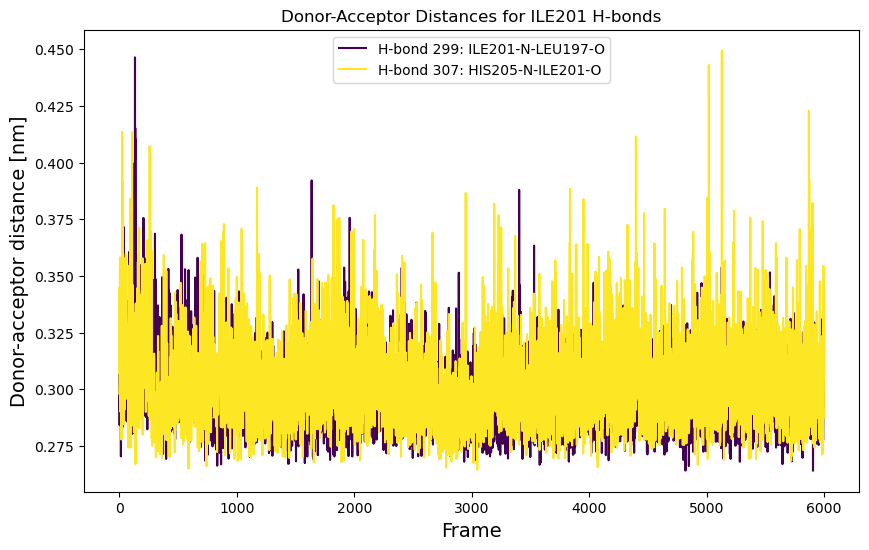

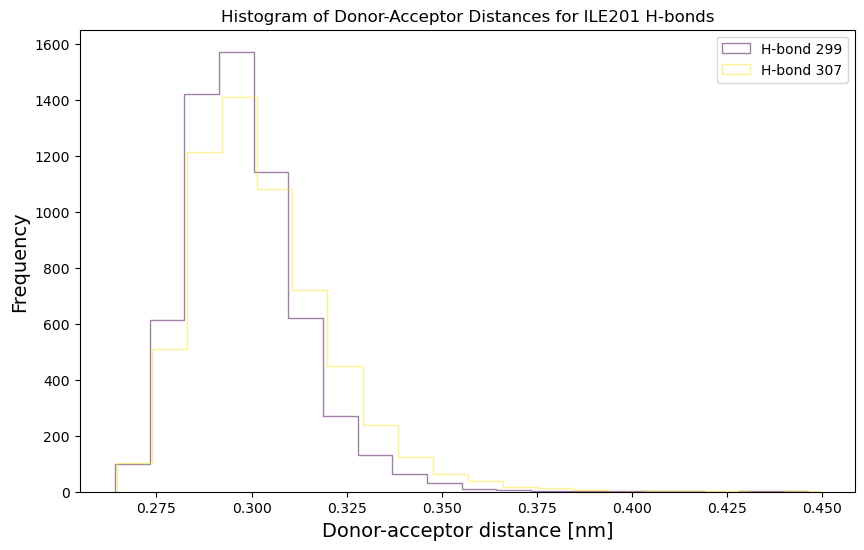

[3318 3319 3267] ARG202-N VAL198-O
[3331 3332 2682] ARG202-NE LEU163-O
[3331 3332 3684] ARG202-NE VAL224-O
[3337 3338 2682] ARG202-NH2 LEU163-O
[3337 3338 3684] ARG202-NH2 VAL224-O
[3397 3398 3341] ALA206-N ARG202-O


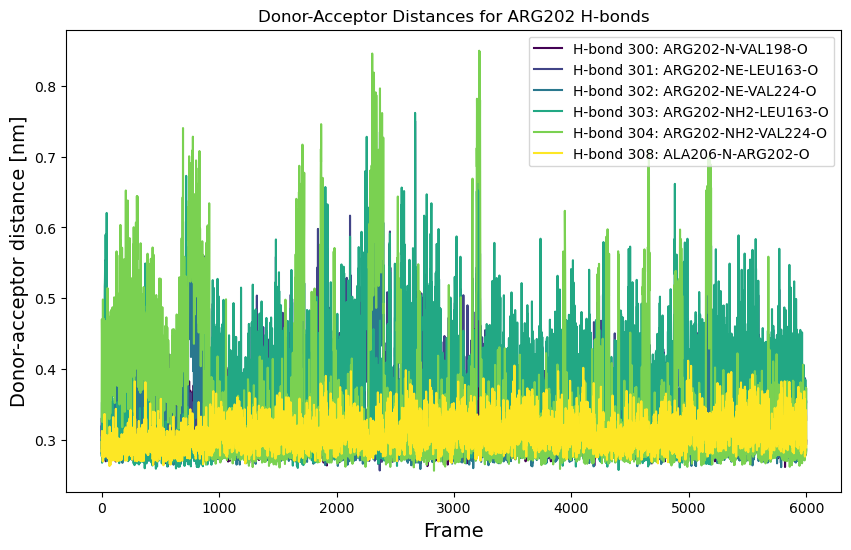

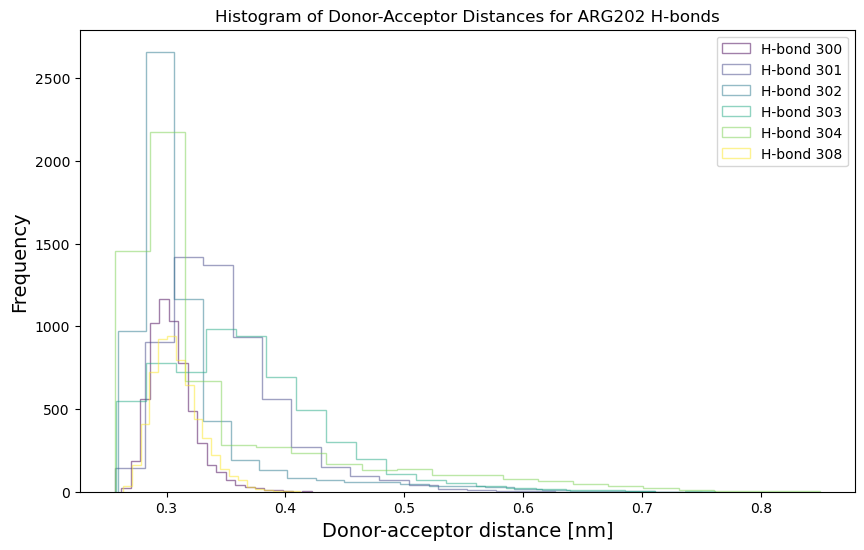

[ 288  289 1029] HIS17-N GLU63-O
[1015 1016  304] GLU63-N HIS17-O
[1829 1830 1026] ARG111-NE GLU63-OE1
[1829 1830 1027] ARG111-NE GLU63-OE2
[1835 1836 1026] ARG111-NH2 GLU63-OE1
[1835 1836 1027] ARG111-NH2 GLU63-OE2
[1840 1841 1026] LEU112-N GLU63-OE1
[1840 1841 1027] LEU112-N GLU63-OE2
[1859 1860 1026] THR113-N GLU63-OE1
[1859 1860 1027] THR113-N GLU63-OE2
[1869 1870 1026] THR113-OG1 GLU63-OE1
[1869 1870 1027] THR113-OG1 GLU63-OE2


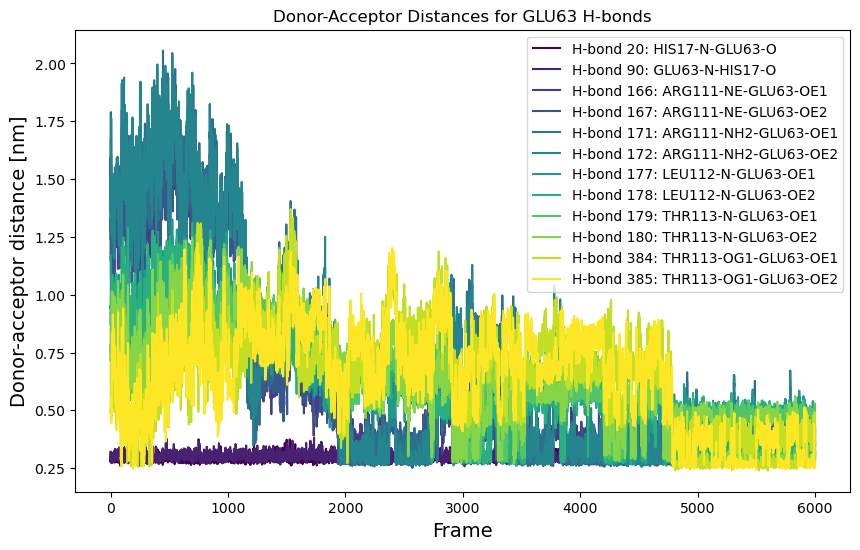

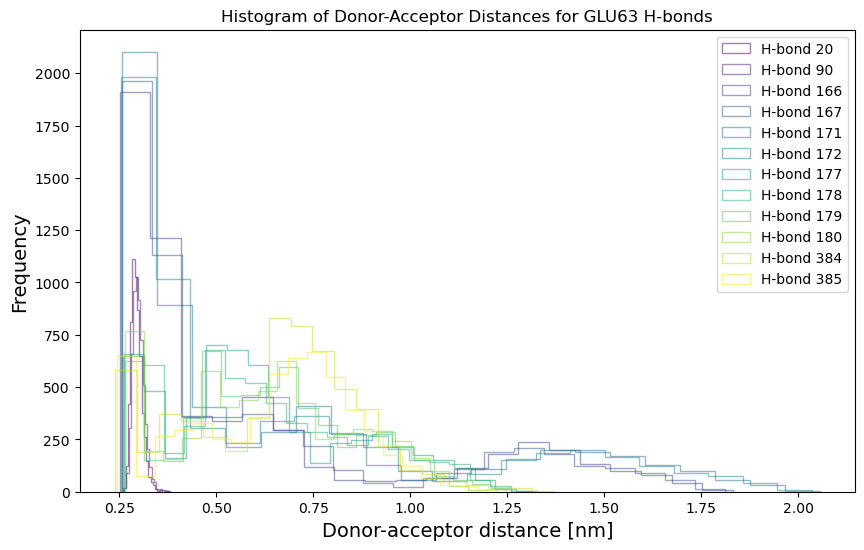

In [199]:
# H-bonds of interest
def plot_hbonds(hbonds, hbond_indices, trj, top, list_name):
    colors = plt.cm.viridis(np.linspace(0, 1, len(hbond_indices)))
    
    plt.figure(figsize=(10, 6))

    for i, Hbond_index in enumerate(hbond_indices):
        hbond = hbonds[Hbond_index]
        donor = top.atom(hbond[0])
        acc = top.atom(hbond[2])
        print(hbond, donor, acc)

        da_distance = md.compute_distances(trj, [[hbond[0], hbond[2]]], periodic=False)
        
        plt.plot(da_distance, color=colors[i], label=f'H-bond {Hbond_index}: {donor}-{acc}')

    plt.legend()
    plt.ylabel('Donor-acceptor distance [nm]', size=14)
    plt.xlabel('Frame', size=14)
    plt.title(f'Donor-Acceptor Distances for {list_name}')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    
    for i, Hbond_index in enumerate(hbond_indices):
        hbond = hbonds[Hbond_index]
        da_distance = md.compute_distances(trj, [[hbond[0], hbond[2]]], periodic=False)
        
        plt.hist(da_distance, histtype='step', bins=20, color=colors[i], label=f'H-bond {Hbond_index}', alpha=0.5)
        
    plt.legend()
    plt.ylabel('Frequency', size=14)
    plt.xlabel('Donor-acceptor distance [nm]', size=14)
    plt.title(f'Histogram of Donor-Acceptor Distances for {list_name}')
    plt.show()
# 0 , 85 --- LEU3
# 1 , 82 --- LEU5
# 4 , 80--- ILE8
# 13 , 366 , 368--- TYR11
# 92 , 364 ---HIS66
# 192 , 390 , 391 , 393 --- TYR128
# 251 , 252 --- TRP167
# 299 , 307 --- ILE201
#300 , 301 , 302 , 303 , 304 , 308 ---ARG202
#20 , 90, 166 , 167 ,171 , 172 , 177 , 178 , 179 , 180 , 384 , 385 ---GLU63
LEU3_hbonds = [0 , 84]  
plot_hbonds(hbonds, LEU3_hbonds, trj, top, 'LEU3 H-bonds')  
LEU5_hbonds = [1 , 82]  
plot_hbonds(hbonds, LEU5_hbonds, trj, top, 'LEU5 H-bonds')  
ILE8_hbonds = [4 , 80]  
plot_hbonds(hbonds, ILE8_hbonds, trj, top, 'ILE8 H-bonds') 
TYR11_hbonds = [13 , 366 , 368]  
plot_hbonds(hbonds, TYR11_hbonds, trj, top, 'TYR11 H-bonds') 
HIS66_hbonds = [92 , 364]  
plot_hbonds(hbonds, HIS66_hbonds, trj, top, 'HIS66 H-bonds')
TYR128_hbonds = [192 , 390 , 391 , 393]  
plot_hbonds(hbonds, TYR128_hbonds, trj, top, 'TYR128 H-bonds')
TRP167_hbonds = [251 , 252]  
plot_hbonds(hbonds, TRP167_hbonds, trj, top, 'TRP167 H-bonds')
ILE201_hbonds = [299 , 307]  
plot_hbonds(hbonds, ILE201_hbonds, trj, top, 'ILE201 H-bonds')
ARG202_hbonds = [300 , 301 , 302 , 303 , 304 , 308]  
plot_hbonds(hbonds, ARG202_hbonds, trj, top, 'ARG202 H-bonds')
GLU63_hbonds = [20 , 90, 166 , 167 ,171 , 172 , 177 , 178 , 179 , 180 , 384 , 385]  
plot_hbonds(hbonds, GLU63_hbonds, trj, top, 'GLU63 H-bonds')

In [7]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3)) #this is done because this has lots of dimensions
print(reduced_cartesian.shape) #look at as a function of time, and project onto first 2 components
# makes co-variance matrix, looking at how much the positions of atoms are coorelated across the residues
# look into linear algebra eigen values and vectors....

(6000, 2)


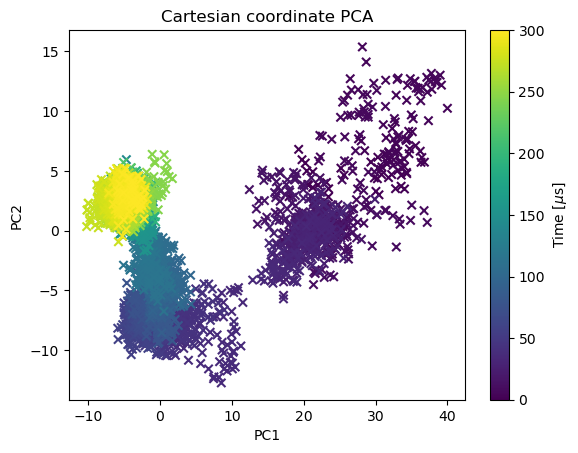

In [10]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')
#when you reduce dimensionality for PCA, you want to project properties back onto there to make sure that you have captured relevant information

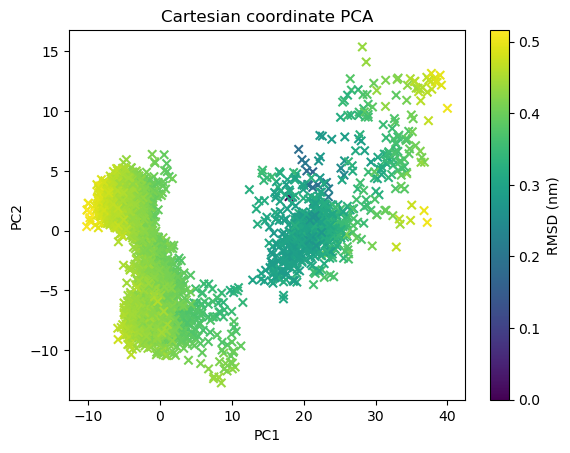

In [11]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

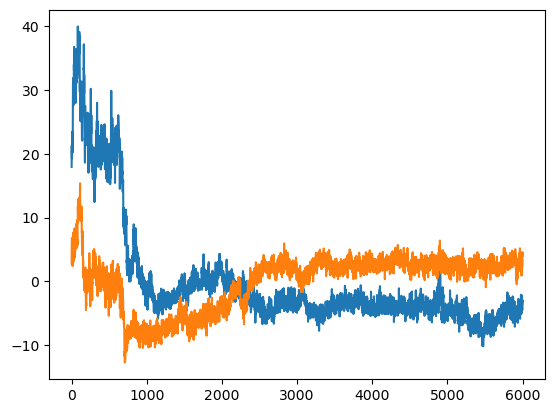

In [202]:
plt.plot(PC1)
plt.plot(PC2)
# PC2 shows the most change 

In [69]:
#Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


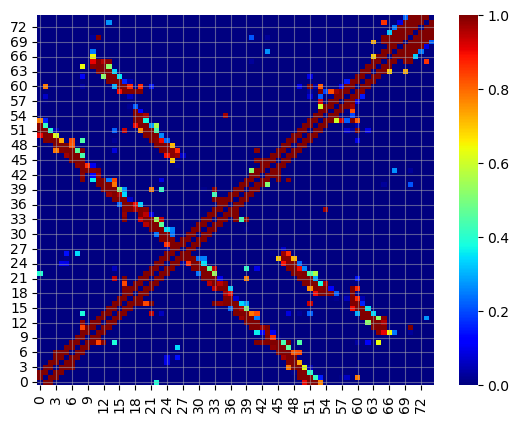

In [70]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)

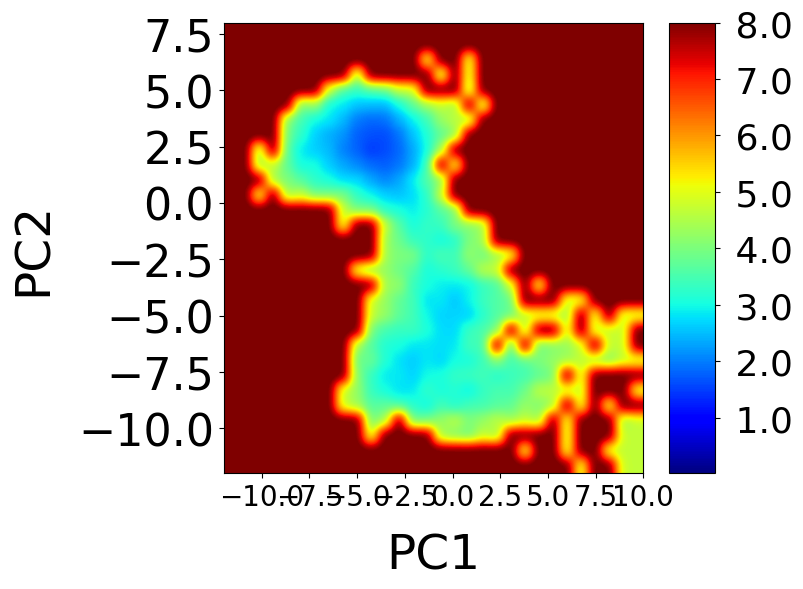

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate free energy
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1 = reduced_cartesian[:, 0]
PC2 = reduced_cartesian[:, 1]

# Calculate free energy with new ranges for PC1 and PC2
dG, xedges, yedges = free_energy(PC2, PC1, 300, -12, 8, -12, 10)

# Create figure and axis
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')

# Set colorbar
cbar_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10)
cb.ax.tick_params(labelsize=26)

# Set axis labels and ticks
plt.xlabel("PC1", size=35, labelpad=15)
plt.ylabel("PC2", size=35, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=32)

# Set axis limits and color limits
plt.xlim(-12, 10)
plt.ylim(-12, 8)
plt.clim(vmin=0.01, vmax=8.0)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


RegA has 2 main states when unbound. 

In [122]:
PC_state1_indices = np.where(PC2 < -2)[0]  
PC_state2_indices = np.where(PC2 > -2)[0]  

PC_state1_selected = PC_state1_indices[::5]
PC_state2_selected = PC_state2_indices[::5]
print(PC_state1_selected)
print(PC_state2_selected)

[ 189  194  248  449  478  494  500  519  563  590  640  646  651  657
  669  674  681  686  691  696  701  706  711  716  721  726  731  736
  741  746  751  756  761  766  771  776  781  786  791  796  801  806
  811  816  821  826  831  836  841  846  851  856  861  866  871  876
  881  886  891  896  901  906  911  916  921  926  931  936  941  946
  951  956  961  966  971  976  981  986  991  996 1001 1006 1011 1016
 1021 1026 1031 1036 1041 1046 1051 1056 1061 1066 1071 1076 1081 1086
 1091 1096 1101 1106 1111 1116 1121 1126 1131 1136 1141 1146 1151 1156
 1161 1166 1171 1176 1181 1186 1191 1196 1201 1206 1211 1216 1221 1226
 1231 1236 1241 1246 1251 1256 1261 1266 1271 1276 1281 1286 1291 1296
 1301 1306 1311 1316 1321 1326 1331 1336 1341 1346 1351 1356 1361 1366
 1371 1376 1381 1386 1391 1396 1401 1406 1411 1416 1421 1426 1431 1436
 1441 1446 1451 1456 1461 1466 1471 1476 1481 1486 1491 1496 1501 1506
 1511 1516 1521 1526 1531 1536 1541 1546 1551 1556 1561 1566 1571 1576
 1581 

Evaluate residue of interest stability through autocorrelation functions and isolate long autocorrelations.

Residue LEU3 (Index 2)


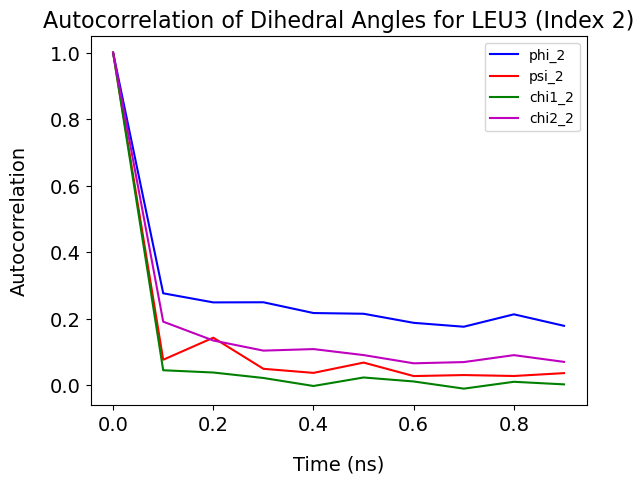

Residue LEU5 (Index 4)


C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


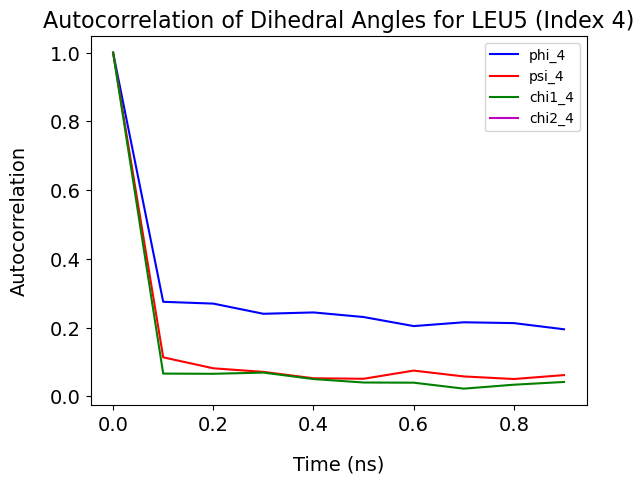

Residue ILE8 (Index 7)


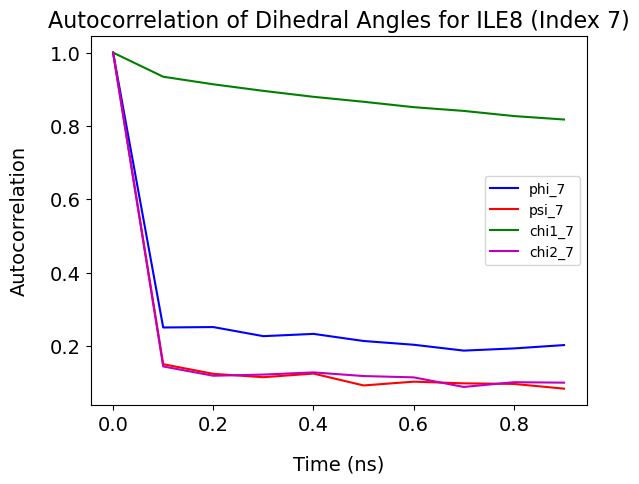

Residue TYR11 (Index 10)


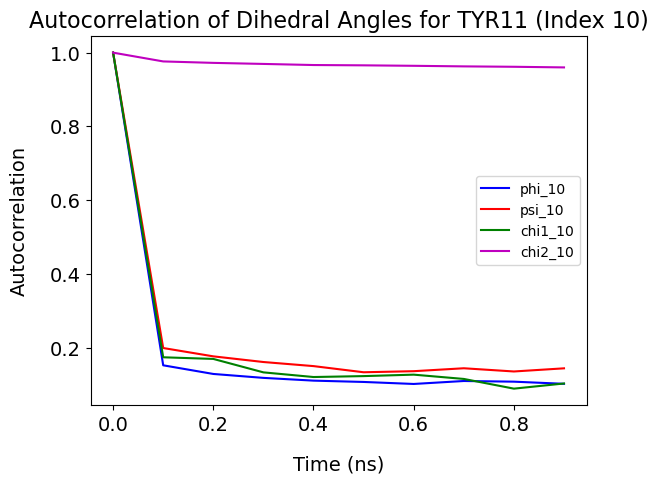

Residue HIS66 (Index 65)


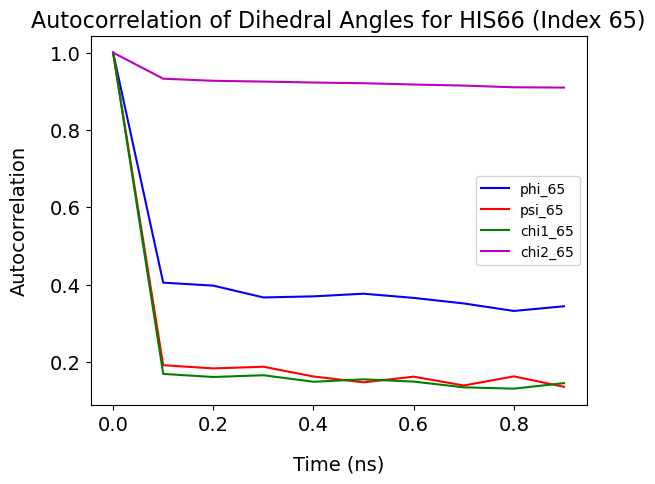

Residue TYR128 (Index 127)


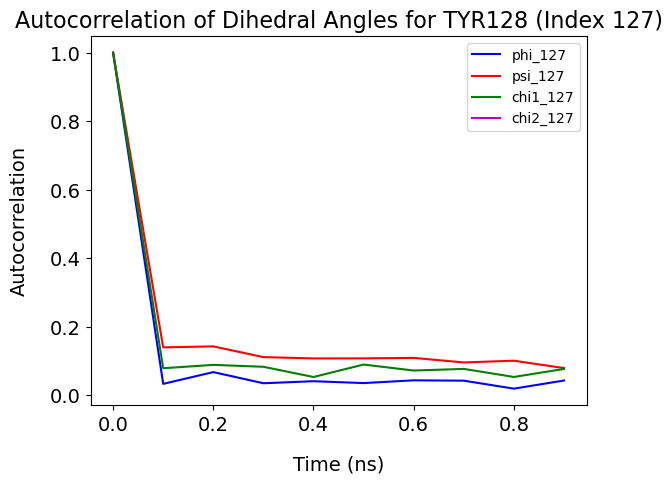

Residue TRP167 (Index 166)


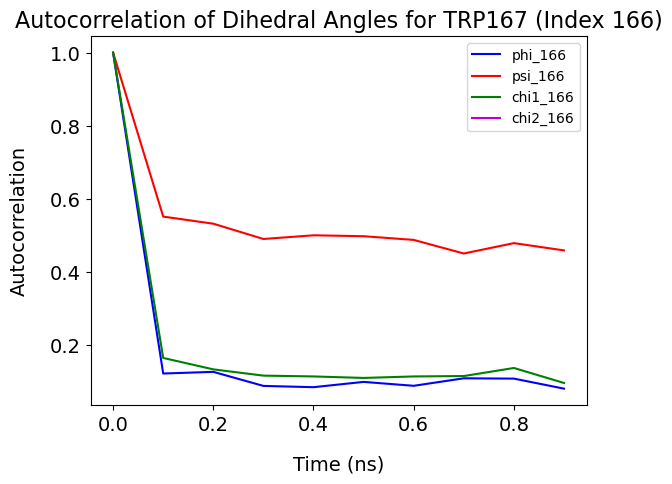

Residue ILE201 (Index 200)


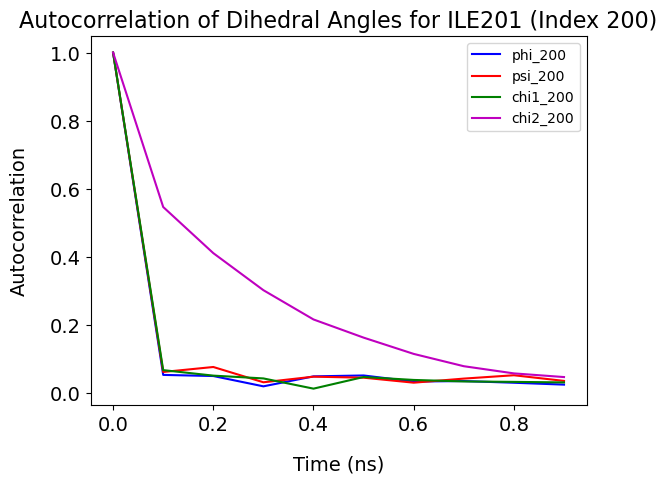

Residue ARG202 (Index 201)


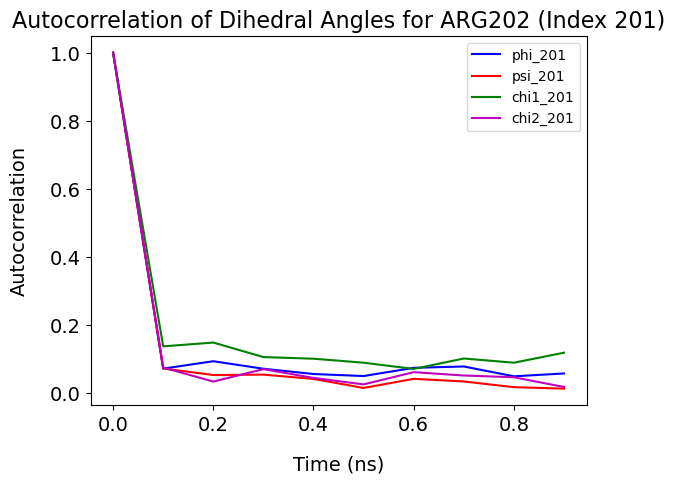

In [212]:
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

res_interest= [2, 4, 7, 10, 65, 127, 166, 200, 201]
# Define time in microseconds
time = np.linspace(0, 600, trj.n_frames)
lags = range(10)  # Takes time series and correlates it to itself but lagged by 10 steps

# Function to get residue name and sequence number
def get_residue_info(residue_index, topology):
    residue = topology.residue(residue_index)
    return residue.name, residue.resSeq

# Iterate over each residue in array
for res in res_interest:
    resname, resnum = get_residue_info(res, trj.topology)
    print(f"Residue {resname}{resnum} (Index {res})")

    # Calculate autocorrelation for phi, psi, chi1, and chi2 for the current residue
    phi_acf = autocorr1(dihedral_dict['phi'].get(res, []), lags)
    psi_acf = autocorr1(dihedral_dict['psi'].get(res, []), lags)
    chi1_acf = autocorr1(dihedral_dict.get('chi1', {}).get(res, []), lags)
    chi2_acf = autocorr1(dihedral_dict.get('chi2', {}).get(res, []), lags)

    # Plot autocorrelation for each dihedral angle
    plt.plot(time[lags], phi_acf, color='b', label=f'phi_{res}')
    plt.plot(time[lags], psi_acf, color='r', label=f'psi_{res}')
    plt.plot(time[lags], chi1_acf, color='g', label=f'chi1_{res}')
    plt.plot(time[lags], chi2_acf, color='m', label=f'chi2_{res}')

    plt.xlabel("Time (ns)", size=14, labelpad=15)
    plt.ylabel("Autocorrelation", size=14, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Autocorrelation of Dihedral Angles for {resname}{resnum} (Index {res})", size=16)
    plt.legend()
    plt.show()
#This will get angry when it encounters residues that don't have all of the dihedral residues, but thats okay. I will ignore this. 

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

auto_corr_time_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames)), lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue}: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_dict.keys(): \
            auto_corr_time_dict[angle]={}
        auto_corr_time_dict[angle][residue] = - 1/linfit_angle[0]
        

C:\Users\grace\AppData\Local\Temp\ipykernel_19564\1031893212.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2: 0.13822250585550447
Autocorrelation time for phi at residues 3: 0.16910131538394158
Autocorrelation time for phi at residues 4: 0.13796794054221959
Autocorrelation time for phi at residues 5: 0.1303999803113807
Autocorrelation time for phi at residues 6: 0.1287670864351964
Autocorrelation time for phi at residues 7: 0.1335504836634026
Autocorrelation time for phi at residues 8: 0.11452911100226972
Autocorrelation time for phi at residues 9: 0.11195220464467742
Autocorrelation time for phi at residues 10: 0.11808129369896368
Autocorrelation time for phi at residues 11: 0.11794150523541497
Autocorrelation time for phi at residues 12: 0.12393908073583092
Autocorrelation time for phi at residues 13: 0.11464976565525305
Autocorrelation time for phi at residues 14: 0.11251182717366191
Autocorrelation time for phi at residues 15: 0.13508326852940133
Autocorrelation time for phi at residues 16: 0.17639983584916408
Autocorrelation time for phi at resi

C:\Users\grace\AppData\Local\Temp\ipykernel_19564\827683006.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_110 has correlation time longer than 0.9 microseconds: 4.5251215372236615 microseconds.
Residue phi_115 has correlation time longer than 0.9 microseconds: 2.0063268748709318 microseconds.
Residue psi_88 has correlation time longer than 0.9 microseconds: 0.9538995645529598 microseconds.
Residue psi_110 has correlation time longer than 0.9 microseconds: 1.0577895895283504 microseconds.
Residue psi_115 has correlation time longer than 0.9 microseconds: 1.281568958204075 microseconds.
Residue chi1_7 has correlation time longer than 0.9 microseconds: 1.4730641254129626 microseconds.
Residue chi1_29 has correlation time longer than 0.9 microseconds: 1.0028373754332225 microseconds.
Residue chi1_92 has correlation time longer than 0.9 microseconds: 1.8327484211956526 microseconds.
Residue chi1_147 has correlation time longer than 0.9 microseconds: 2.9913919930783974 microseconds.
Residue chi1_152 has correlation time longer than 0.9 microseconds: 4.701048272352556 microseconds.
Re

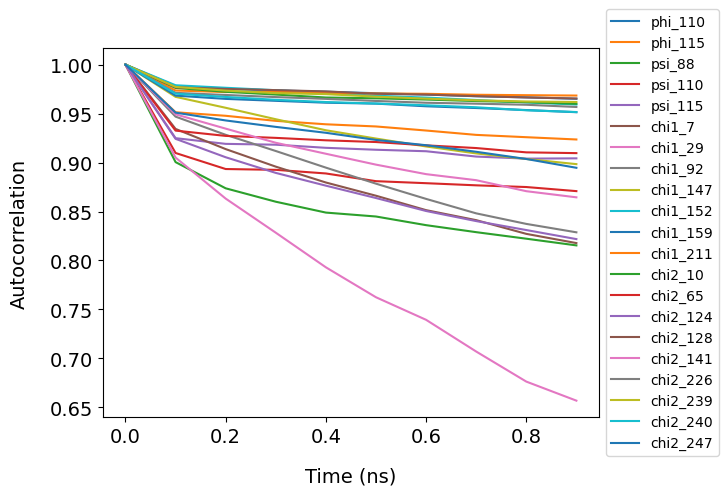

In [214]:
import numpy as np
import matplotlib.pyplot as plt
# Define threshold value here (in nanoseconds)
threshold = 0.9

residues_above_threshold = []
# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_data, lags)
        # Calculate correlation time 
        correlation_time = 0
        if dihedral_acf[1] > 0:
            popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")
# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Time (ns)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

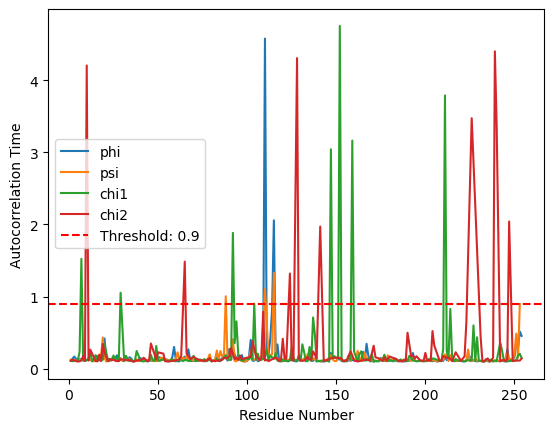

In [215]:
#This gives me a plot of the autocorrelation times for each dihedral angle for all residues. 
for angle in auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  
plt.legend()
plt.show()

In [216]:
#Do this again for each PC states
PC_state1_auto_corr_time_dict = {}

# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Get dihedral data for the current angle and residue, and slice using PC_state1_indices
        dihedral_data = dihedral_dict[angle][residue]
        dihedral_data_pc_state1 = dihedral_data[PC_state1_indices]
        
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_data_pc_state1, lags)
        
        # Check if the values in angle_acf[:2] are positive and non-zero
        if np.all(angle_acf[:2] > 0):
            # Define a linear function for regression
            def linear_func(t, m, c):
                return m * t + c

            # Perform linear regression for each autocorrelation curve using the first two lag values
            linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))

            # Print the slopes
            correlation_time = -1 / linfit_angle[0]
            print(f"Autocorrelation time for {angle} at residue {residue}: {correlation_time}")
            
            if angle not in PC_state1_auto_corr_time_dict:
                PC_state1_auto_corr_time_dict[angle] = {}
            PC_state1_auto_corr_time_dict[angle][residue] = correlation_time
print(PC_state1_auto_corr_time_dict)

C:\Users\grace\AppData\Local\Temp\ipykernel_19564\1937218375.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))


Autocorrelation time for phi at residue 2: 0.06541961458833348
Autocorrelation time for phi at residue 3: 0.10679368322834215
Autocorrelation time for phi at residue 4: 0.08051229023832579
Autocorrelation time for phi at residue 5: 0.0781552546128808
Autocorrelation time for phi at residue 6: 0.06697263737546792
Autocorrelation time for phi at residue 7: 0.07350197306226351
Autocorrelation time for phi at residue 8: 0.04218006947220344
Autocorrelation time for phi at residue 9: 0.04170473302483419
Autocorrelation time for phi at residue 10: 0.04493781052582302
Autocorrelation time for phi at residue 11: 0.04101033380678216
Autocorrelation time for phi at residue 12: 0.0670429298670306
Autocorrelation time for phi at residue 13: 0.04197682192705125
Autocorrelation time for phi at residue 14: 0.045247045386313925
Autocorrelation time for phi at residue 15: 0.09710536474310905
Autocorrelation time for phi at residue 16: 0.08787837759121646
Autocorrelation time for phi at residue 17: 0.091

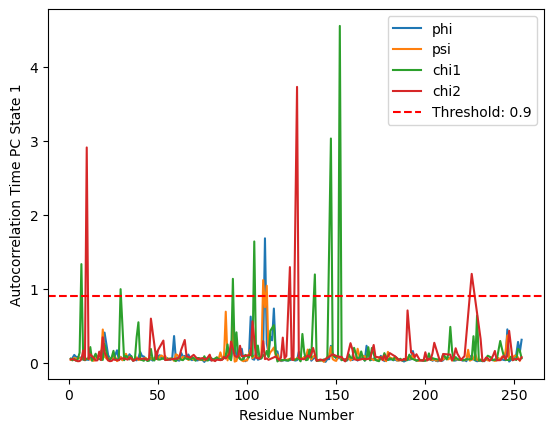

In [217]:
for angle in PC_state1_auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(PC_state1_auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(PC_state1_auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time PC State 1')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

In [218]:
#Do this again for each PC states
PC_state2_auto_corr_time_dict = {}

# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Get dihedral data for the current angle and residue, and slice using PC_state1_indices
        dihedral_data = dihedral_dict[angle][residue]
        dihedral_data_pc_state2 = dihedral_data[PC_state2_indices]
        
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_data_pc_state2, lags)
        
        # Check if the values in angle_acf[:2] are positive and non-zero
        if np.all(angle_acf[:2] > 0):
            # Define a linear function for regression
            def linear_func(t, m, c):
                return m * t + c

            # Perform linear regression for each autocorrelation curve using the first two lag values
            linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))

            # Print the slopes
            correlation_time = -1 / linfit_angle[0]
            print(f"Autocorrelation time for {angle} at residue {residue}: {correlation_time}")
            
            # Add the calculated value to the dictionary
            if angle not in PC_state2_auto_corr_time_dict:
                PC_state2_auto_corr_time_dict[angle] = {}
            PC_state2_auto_corr_time_dict[angle][residue] = correlation_time

# Print the resulting dictionary for verification
print(PC_state2_auto_corr_time_dict)

C:\Users\grace\AppData\Local\Temp\ipykernel_19564\55895275.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))


Autocorrelation time for phi at residue 2: 0.08060788512380133
Autocorrelation time for phi at residue 3: 0.10595634789866659
Autocorrelation time for phi at residue 4: 0.07028677891565711
Autocorrelation time for phi at residue 5: 0.0632147342256919
Autocorrelation time for phi at residue 6: 0.06496515632657905
Autocorrelation time for phi at residue 7: 0.0721220151677723
Autocorrelation time for phi at residue 8: 0.04867914085810019
Autocorrelation time for phi at residue 9: 0.04309326368437202
Autocorrelation time for phi at residue 10: 0.0571525208625509
Autocorrelation time for phi at residue 11: 0.056235338132956066
Autocorrelation time for phi at residue 12: 0.05600748925188795
Autocorrelation time for phi at residue 13: 0.04540783929664131
Autocorrelation time for phi at residue 14: 0.04448842759412529
Autocorrelation time for phi at residue 15: 0.062884175161816
Autocorrelation time for phi at residue 16: 0.09453035596049877
Autocorrelation time for phi at residue 17: 0.046659

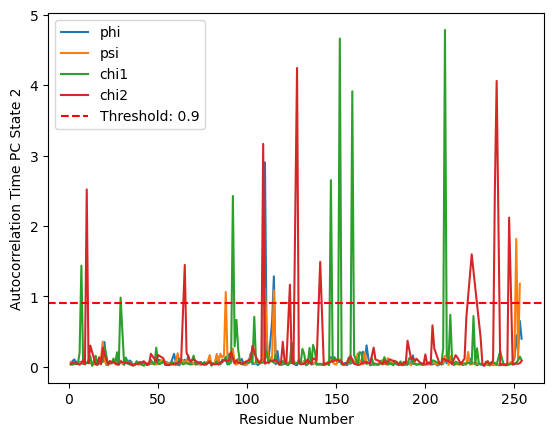

In [221]:
for angle in PC_state2_auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(PC_state2_auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(PC_state2_auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time PC State 2')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

Identify trends in dihedral angles across frames for residues of interest.

Residue LEU3 (Index 2)


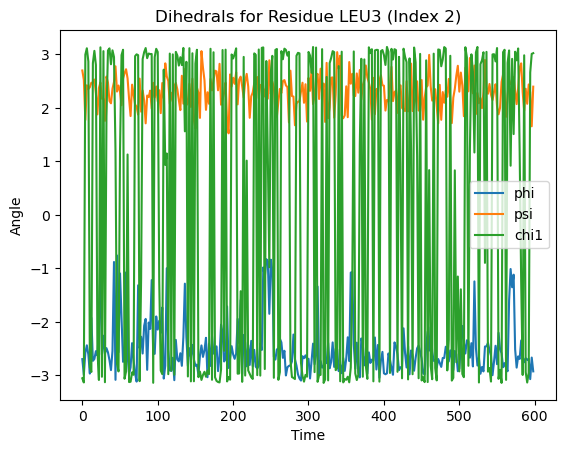

Residue LEU5 (Index 4)


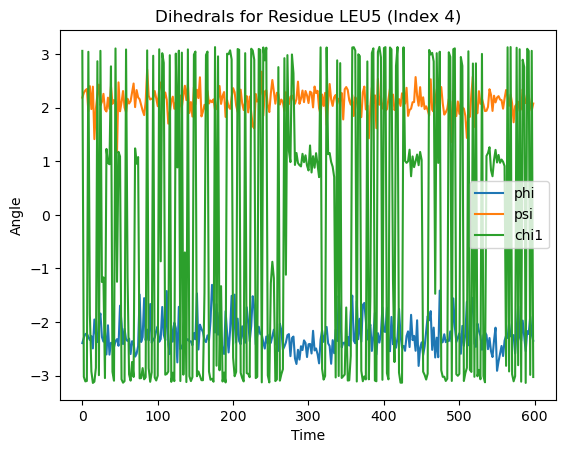

Residue ILE8 (Index 7)


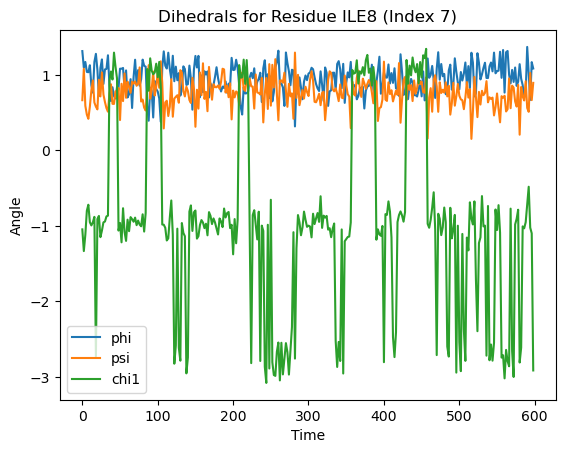

Residue TYR11 (Index 10)


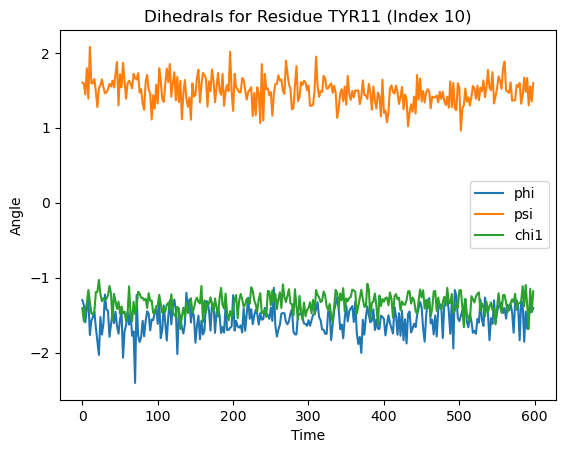

Residue HIS66 (Index 65)


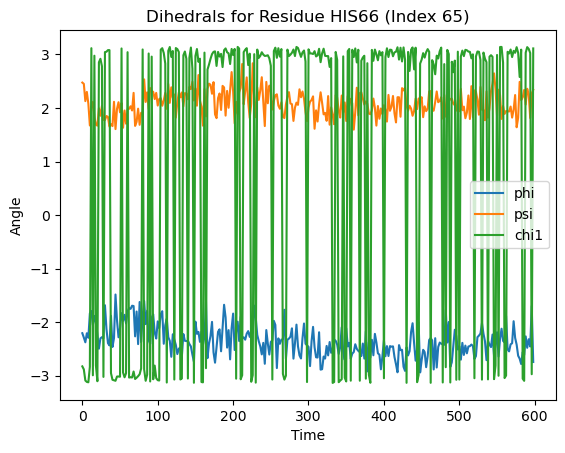

Residue TYR128 (Index 127)


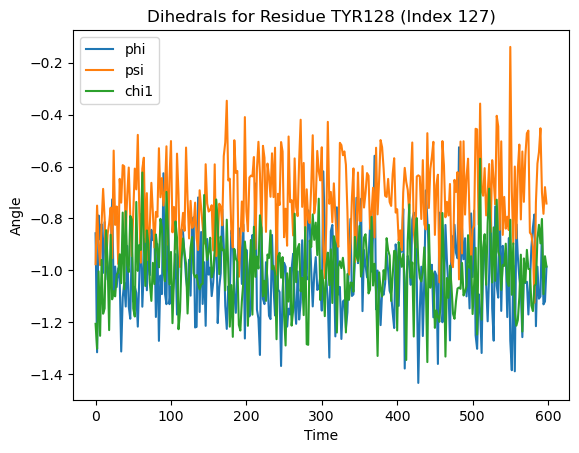

Residue TRP167 (Index 166)


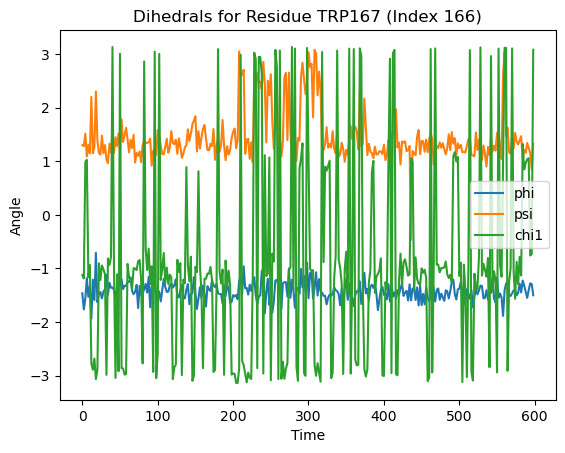

Residue ILE201 (Index 200)


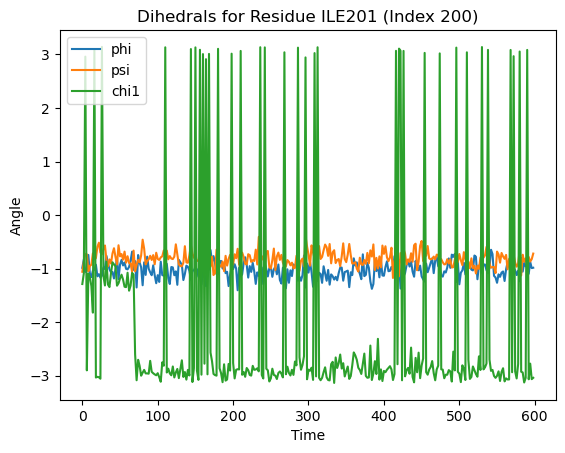

Residue ARG202 (Index 201)


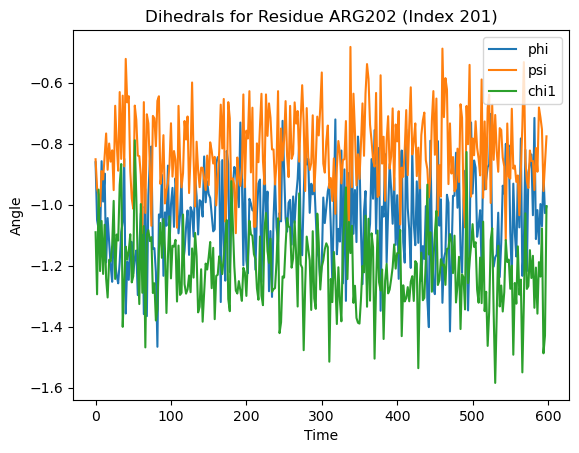

In [220]:
# Function to get residue name and sequence number
def get_residue_info(residue_index, topology):
    residue = topology.residue(residue_index)
    return residue.name, residue.resSeq

for res in res_interest:
    resname, resnum = get_residue_info(res, trj.topology)
    print(f"Residue {resname}{resnum} (Index {res})")
    
    plt.plot(time[::20], dihedral_dict['phi'][res][::20], label="phi")
    plt.plot(time[::20], dihedral_dict['psi'][res][::20], label="psi")
    plt.plot(time[::20], dihedral_dict['chi1'][res][::20], label="chi1")

    plt.xlabel('Time')
    plt.ylabel('Angle')
    plt.title(f'Dihedrals for Residue {resname}{resnum} (Index {res})')
    plt.legend()
    plt.show()

Plot RMSD vs delta G. This is not very informative since there are minimal shifts in RMSD.

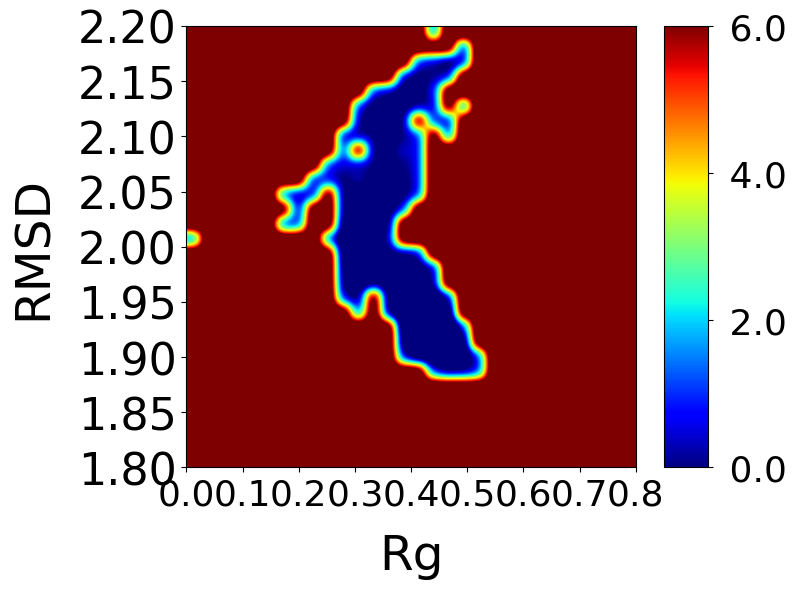

In [230]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 1.8, 2.2, 0, 0.8)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [21]:
#Here I am defining all the functions for my block errors
import pyblock
from itertools import chain
def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error

def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr

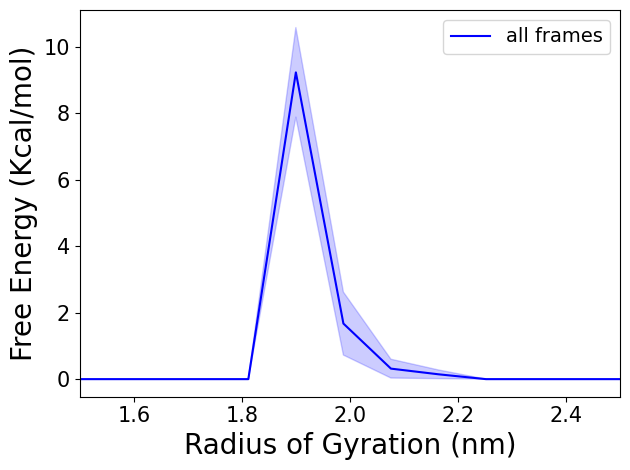

In [225]:
Rg_all, edges, u_err = histo_blockerror(rg, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_all, c='blue', label='all frames')
plt.fill_between(edges, Rg_all-u_err, Rg_all+u_err, color='blue', alpha=0.2)

plt.xlim(1.5, 2.5)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

Plot Rg as a funciton of delta G. Get a sense for relative structural flexibility and stability across protein- ligand complexes.

C:\Users\grace\AppData\Local\Temp\ipykernel_25976\3111160101.py:54: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


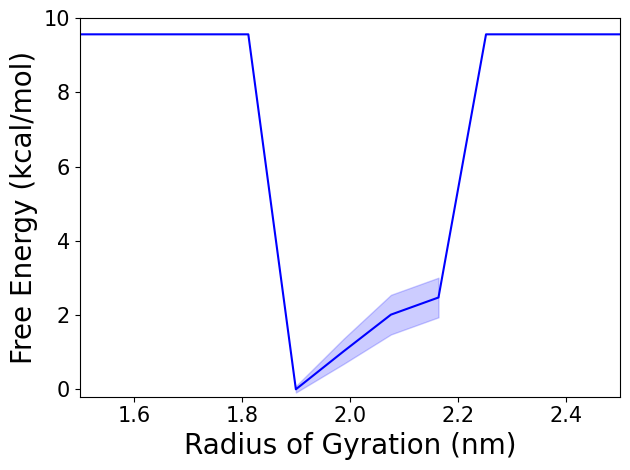

In [24]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 10)
plt.xlim(1.5, 2.5)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+ 'RegA_rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()
